In [214]:
import numpy as np
import pandas as pd
from functools import reduce
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import scipy.stats as stats
from MissForestExtra import MissForestExtra as mfe
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import KFold
import sklearn.neighbors._base
import sys
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base
from missingpy import MissForest
import pingouin as pg
from statsmodels.miscmodels.ordinal_model import OrderedModel
import re

In [483]:
"""Function to consolidate datasets from different years into a single dataframe with common column names"""

def batch_read(path):
    dfs = [pd.read_sas(filename) for filename in glob.glob(path + "/*.XPT")]
    
    #Select columns common to all dataframes
    common_cols = [dfs[-1].columns]
    for df in dfs:
        cols = np.intersect1d(common_cols, df.columns)
        common_cols = cols
    
    #Organize each dataframe based on common_cols
    dfs_new_cols = []
    for df in dfs:
        dfs_new_cols.append(df[common_cols])
    
    #concatenate dfs
    dfs_concatenated = pd.concat(dfs_new_cols, axis = 0)    
    return dfs_concatenated

In [3]:
"""Let's read in the mental health-depression questionnaire survey across all years (2005-2018)"""
depression_screen = batch_read('/Users/jnl741/Desktop/NHANES/Mental_health')

In [4]:
depression_screen.columns

Index(['DPQ010', 'DPQ020', 'DPQ030', 'DPQ040', 'DPQ050', 'DPQ060', 'DPQ070',
       'DPQ080', 'DPQ090', 'DPQ100', 'SEQN'],
      dtype='object')

In [5]:
"""Rename columns"""

depression_screen_new_cols = {'SEQN':'SEQN',
                                 'DPQ010':'Have little interest in doing things',
                                 'DPQ020':'Feeling down depressed or hopeless',
                                 'DPQ030':'Sleeping issues',
                                 'DPQ040':'Feeling tired or low energy',
                                 'DPQ050':'Poor appetite or overeating',
                                 'DPQ060':'Feeling bad about self',
                                 'DPQ070':'Trouble coencentrating',
                                 'DPQ080':'Moving or speaking too slow or fast',
                                 'DPQ090':'Thought you would be better of dead',
                                 'DPQ100':'Difficulty these problems have caused'}


depression_screen = depression_screen.rename(columns = depression_screen_new_cols)
depression_screen.columns = depression_screen.columns.str.replace(' ','_')

In [6]:
depression_screen = np.round(depression_screen)

<AxesSubplot:>

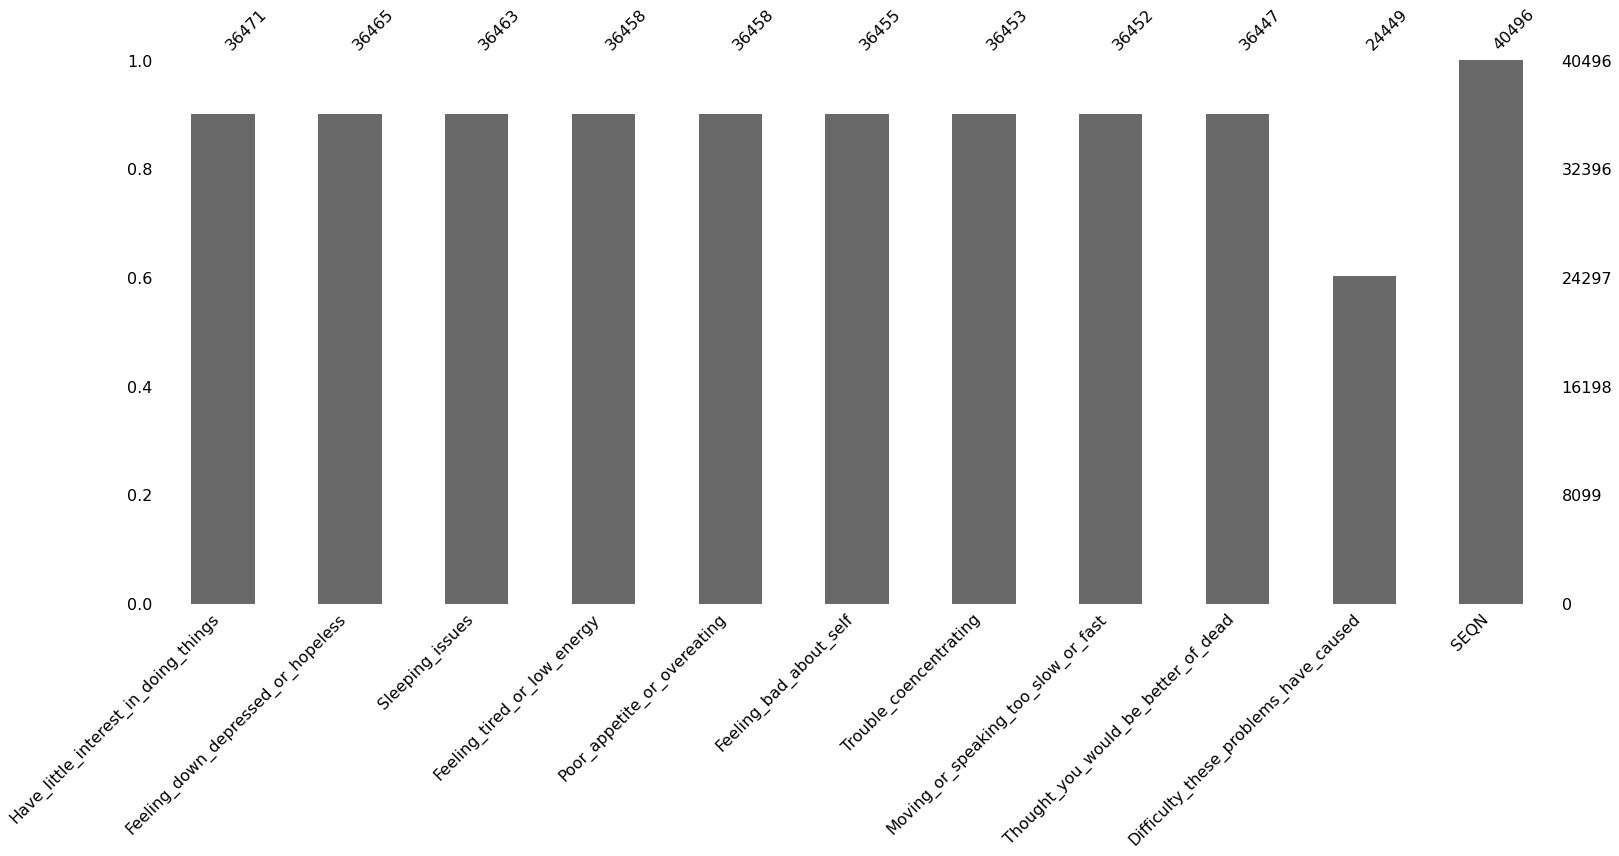

In [7]:
"""Let's evaluate the extent of missing values in the depression screen using the MSNO package"""
msno.bar(depression_screen)


<AxesSubplot:>

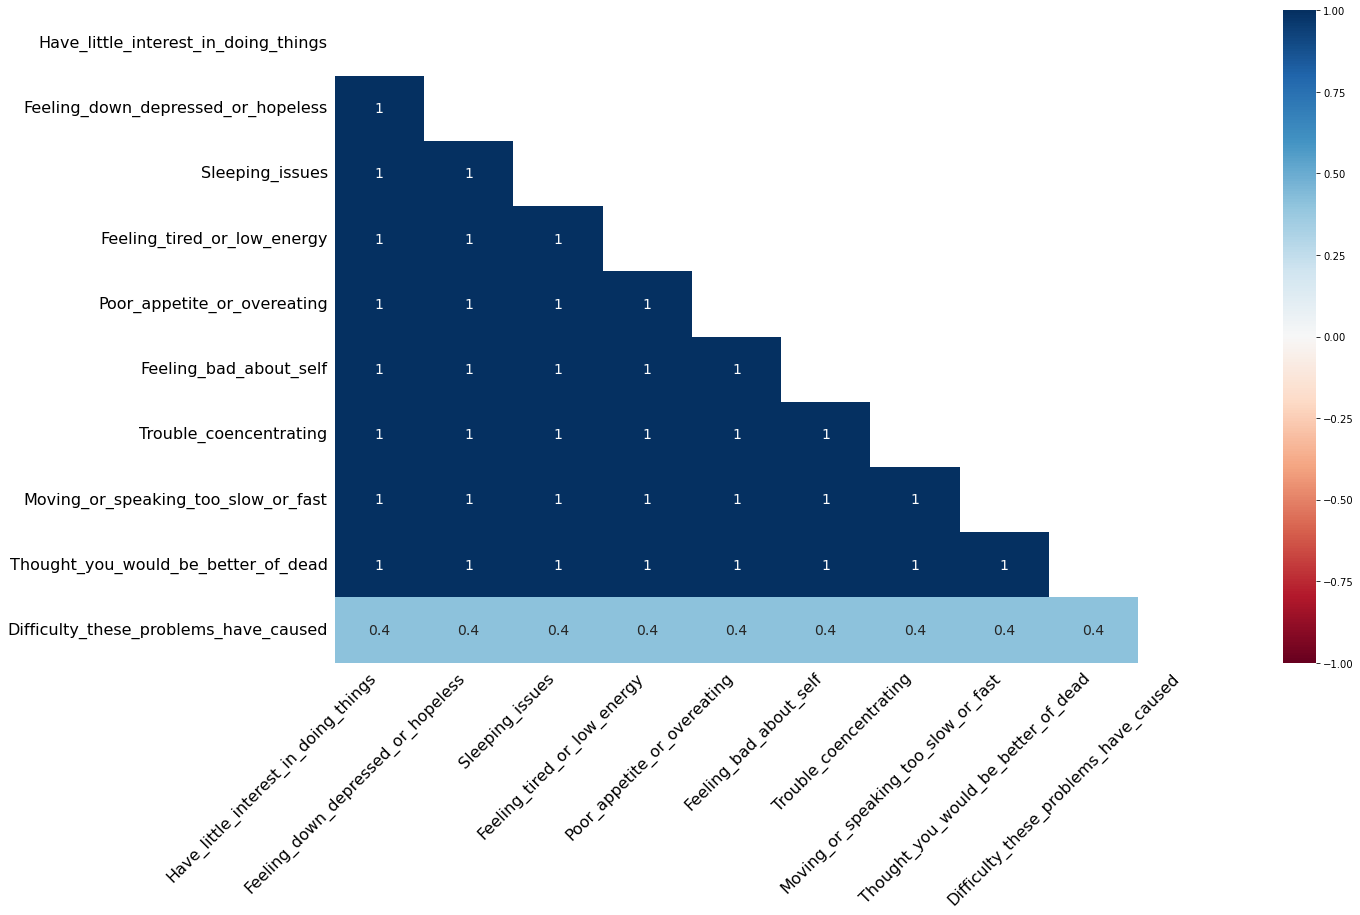

In [8]:
"""Heatmap to display correlations in missing values between columns: 1 means that between two columns, the same
rows have missing values, -1 indicates perfect anticorrelation in missing values. """
msno.heatmap(depression_screen)

In [9]:
"""Drop the 'Difficulty these problems have caused' column, as it is not part of the PHQ-9, the
information it contains is redundant, and about half of the values are missing. 
It appears as though there is perfect correlation (score of 1) between present/absent data 
among the remaining columns, indicating that the same patients have multiple missing values. We will therefore drop 
the rows with missing values."""

depression_screen = depression_screen.drop(labels = 'Difficulty_these_problems_have_caused', axis = 1)



In [10]:
depression_screen.isnull().sum()

Have_little_interest_in_doing_things    4025
Feeling_down_depressed_or_hopeless      4031
Sleeping_issues                         4033
Feeling_tired_or_low_energy             4038
Poor_appetite_or_overeating             4038
Feeling_bad_about_self                  4041
Trouble_coencentrating                  4043
Moving_or_speaking_too_slow_or_fast     4044
Thought_you_would_be_better_of_dead     4049
SEQN                                       0
dtype: int64

In [11]:
"""Lets remove rows containing missing responses to the questionnaire"""
PHQ_9_cols = [column for column in depression_screen.columns if column != 'SEQN']
depression_screen[PHQ_9_cols] = np.where(depression_screen[PHQ_9_cols].isin([7,9]),
                                         np.nan,
                                         depression_screen[PHQ_9_cols])
depression_screen = depression_screen.dropna()
depression_screen.shape

(36259, 10)

In [12]:
"""Let's calculate the PHQ-9 score for each participant. Each question on the questionnaire is scored from 0-3, and 
the overall score is the sum of these individual scores."""

depression_screen['PHQ-9_score'] = depression_screen[PHQ_9_cols].sum(axis = 1)


In [13]:
"""PHQ-9 scores are broken down into 5 groups ranging from 'Not depressed' to 'Severe' depression."""

def depression_rating(x):
    if x <=4:
        Depression_rating = 'Not depressed'
    elif x > 4 and x <= 9:
        Depression_rating = 'Mild'
    elif x > 10 and x <= 14:
        Depression_rating = 'Moderate'
    elif x > 15 and x <= 19:
        Depression_rating = 'Moderately severe'
    else:
        Depression_rating = 'Severe'
    
    return Depression_rating

depression_screen['Depression_rating'] = depression_screen['PHQ-9_score'].apply(depression_rating)


In [14]:
depression_screen['Depression_rating'].value_counts().reindex(['Not depressed',
                                                              'Mild',
                                                              'Moderate',
                                                              'Moderately severe',
                                                              'Severe'])

Not depressed        27317
Mild                  5774
Moderate              1405
Moderately severe      626
Severe                1137
Name: Depression_rating, dtype: int64

In [15]:
"""Demographic data"""

demographics = batch_read('/Users/jnl741/Desktop/NHANES/Demographics')

<AxesSubplot:>

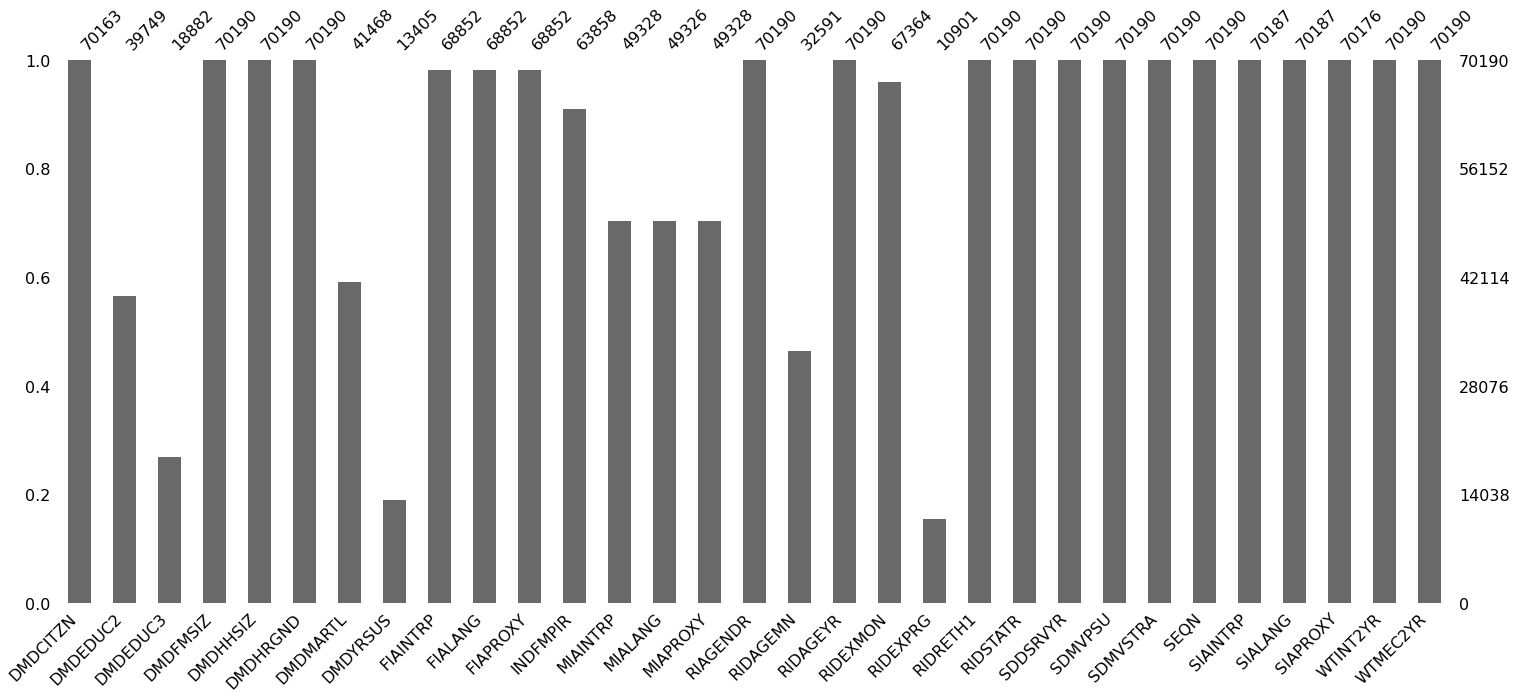

In [16]:
msno.bar(demographics)

In [17]:
demographics_new_cols = {'DMDCITZN':'Citizenship status',
'DMDEDUC2':'Education level, adults',
'DMDEDUC3':'Education level, youth',
'DMDFMSIZ':'Family size',
'DMDHHSIZ':'Household size',
'DMDHRGND':'HH ref person gender',
'DMDMARTL':'Marital status',
'DMDYRSUS':'Length of time in US',
'FIAINTRP':'Interpreter used in family interview',
'FIALANG':'Language of family interview',
'FIAPROXY':'Proxy used in family interview',
'INDFMPIR':'Family poverty to income ratio',
'MIAINTRP':'Interpreter used in MEC interview',
'MIALANG':'Language of MEC Interview',
'MIAPROXY':'Proxy used in MEC interview',
'RIAGENDR':'Gender',
'RIDAGEMN':'Age in months',
'RIDAGEYR':'Age in years',
'RIDEXMON':'Six month time period of exam',
'RIDEXPRG':'Pregnancy status',
'RIDRETH1':'Race/ethnicity',
'RIDSTATR':'Interview/examination status',
'SDDSRVYR':'Data release number',
'SDMVPSU':'Masked variance pseudo-PSU',
'SDMVSTRA':'Masked variance pseudo-stratum',
'SEQN':'SEQN',
'SIAINTRP':'Interpreter used in SP interview',
'SIALANG':'Language of SP interview',
'SIAPROXY':'Proxy used in SP interview',
'WTINT2YR':'Full sample 2 year interview weight',
'WTMEC2YR':'Full sample 2 year MEC exam weight'}


demographics = demographics.rename(columns = demographics_new_cols)
demographics.columns = demographics.columns.str.replace(' ', '_')

In [18]:
demographics = demographics[['SEQN','Age_in_years','Gender','Race/ethnicity']]

In [19]:
demographics.columns

Index(['SEQN', 'Age_in_years', 'Gender', 'Race/ethnicity'], dtype='object')

In [20]:
biochem_profile = batch_read('/Users/jnl741/Desktop/NHANES/Lab_values/Biochem_profile')

<AxesSubplot:>

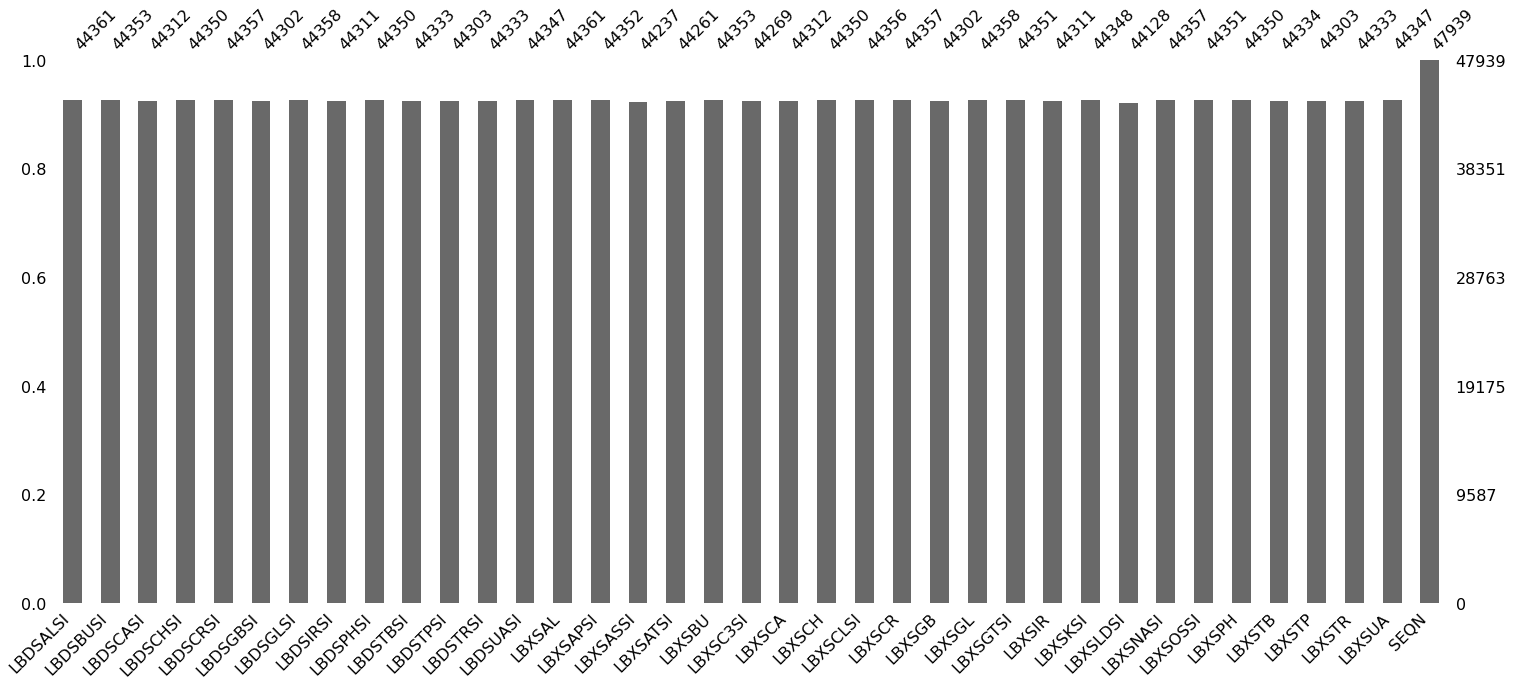

In [21]:
msno.bar(biochem_profile)

In [22]:
biochem_profile_new_cols = {
    'SEQN':'SEQN',
"LBXSAL":"Albumin (g/dL)",
"LBDSALSI":"Albumin (g/L)",
"LBXSATSI":"Alanine aminotransferase ALT (U/L)",
"LBXSASSI":"Aspartate aminotransferase AST (U/L)",
"LBXSAPSI":"Alkaline phosphotase (U/L)",
"LBXSBU":"Blood urea nitrogen (mg/dL)",
"LBDSBUSI":"Blood urea nitrogen (mmol/L)",
"LBXSCA":"Total calcium (mg/dL)",
"LBDSCASI":"Total calcium (mmol/L)",
"LBXSCH":"Cholesterol (mg/dL)",
"LBDSCHSI":"Cholesterol (mmol/L)",
"LBXSC3SI":"Bicarbonate (mmol/L)",
"LBXSCR":"Creatinine (mg/dL)",
"LBDSCRSI":"Creatinine (umol/L)",
"LBXSGTSI":"Gamma glutamyl transferase (U/L)",
"LBXSGL":"Glucose (mg/dL)",
"LBDSGLSI":"Glucose (mmol/L)",
"LBXSIR":"Iron (ug/dL)",
"LBDSIRSI":"Iron (umol/L)",
"LBXSLDSI":"Lactate dehydrogenase (U/L)",
"LBXSPH":"Phosphorus (mg/dL)",
"LBDSPHSI":"Phosphorus (mmol/L)",
"LBXSTB":"Total bilirubin (mg/dL)",
"LBDSTBSI":"Bilirubin (umol/L)",
"LBXSTP":"Total protein (g/dL)",
"LBDSTPSI":"Total protein (g/L)",
"LBXSTR":"Triglycerides (mg/dL)",
"LBDSTRSI":"Triglycerides (mmol/L)",
"LBXSUA":"Uric acid (mg/dL)",
"LBDSUASI":"Uric acid (umol/L)",
"LBXSNASI":"Sodium (mmol/L)",
"LBXSKSI":"Potassium (mmol/L)",
"LBXSCLSI":"Chloride (mmol/L)",
"LBXSOSSI":"Osmolality (mmol/Kg)",
"LBXSGB":"Globulin (g/dL)",
"LBDSGBSI":"Globulin (g/L)"
}

biochem_profile = biochem_profile.rename(columns = biochem_profile_new_cols)
biochem_profile.columns = biochem_profile.columns.str.replace(' ','_')

In [23]:
biochem_profile = biochem_profile.drop(columns = ['Albumin_(g/L)',
                               "Cholesterol_(mmol/L)",
                               "Total_calcium_(mmol/L)",
                               "Creatinine_(umol/L)",
                               'Globulin_(g/dL)',
                               "Blood_urea_nitrogen_(mg/dL)",
                               'Total_calcium_(mg/dL)',
                               'Glucose_(mg/dL)',
                               "Iron_(umol/L)",
                               'Phosphorus_(mg/dL)',
                               'Total_bilirubin_(mg/dL)',
                               'Total_protein_(g/dL)',
                               'Triglycerides_(mg/dL)',
                               "Uric_acid_(umol/L)"])


In [24]:
cholesterol_HDL = batch_read('/Users/jnl741/Desktop/NHANES/Lab_values/Cholesterol_HDL')

<AxesSubplot:>

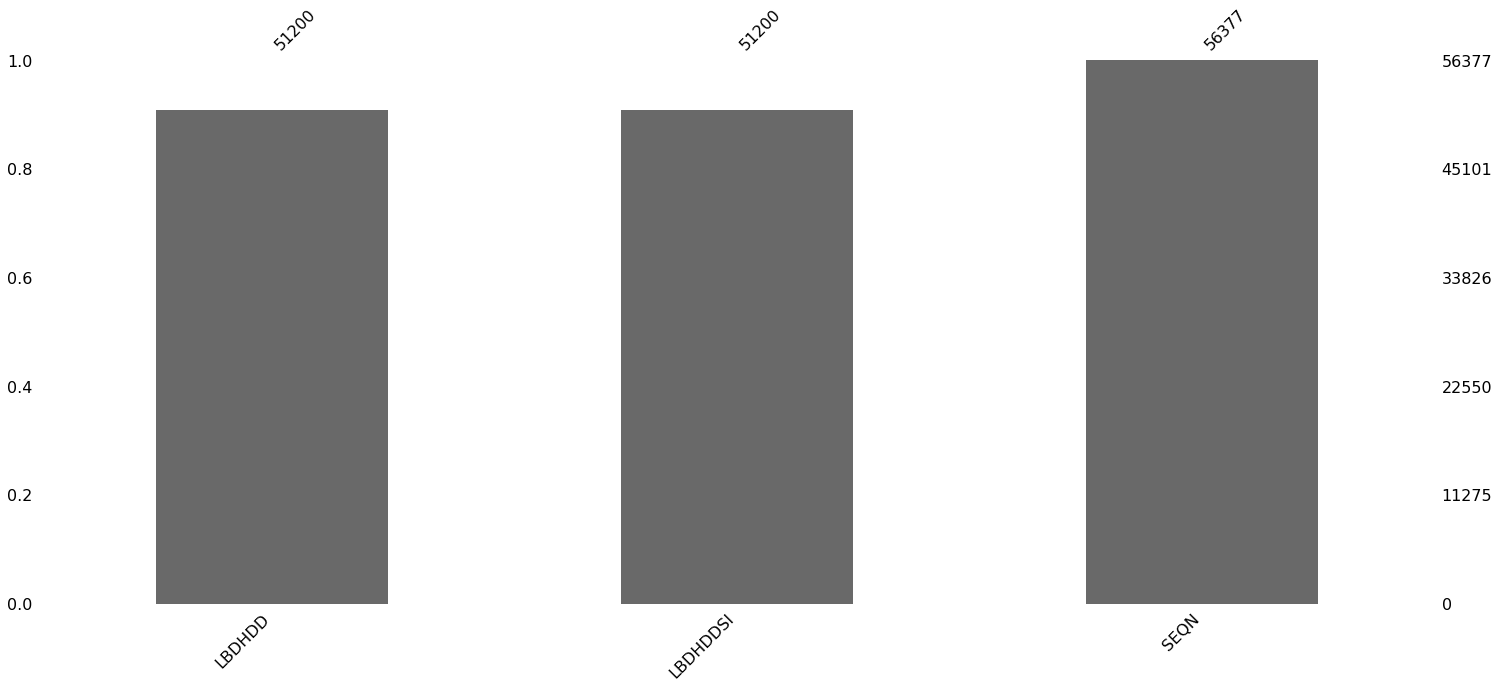

In [25]:
msno.bar(cholesterol_HDL)

In [26]:
cholesterol_HDL_new_cols = {'SEQN':'SEQN',
                            'LBDHDDSI':'Direct HDL-Cholesterol (mmol/L)'}

cholesterol_HDL = cholesterol_HDL.drop(columns = ['LBDHDD'])
cholesterol_HDL = cholesterol_HDL.rename(columns = cholesterol_HDL_new_cols)
cholesterol_HDL.columns = cholesterol_HDL.columns.str.replace(' ','_')

In [27]:
cholesterol_LDL = batch_read('/Users/jnl741/Desktop/NHANES/Lab_values/LDL_and_Triglycerides')

In [28]:
cholesterol_LDL.columns

Index(['LBDLDL', 'LBDLDLSI', 'LBDTRSI', 'LBXTR', 'SEQN', 'WTSAF2YR'], dtype='object')

<AxesSubplot:>

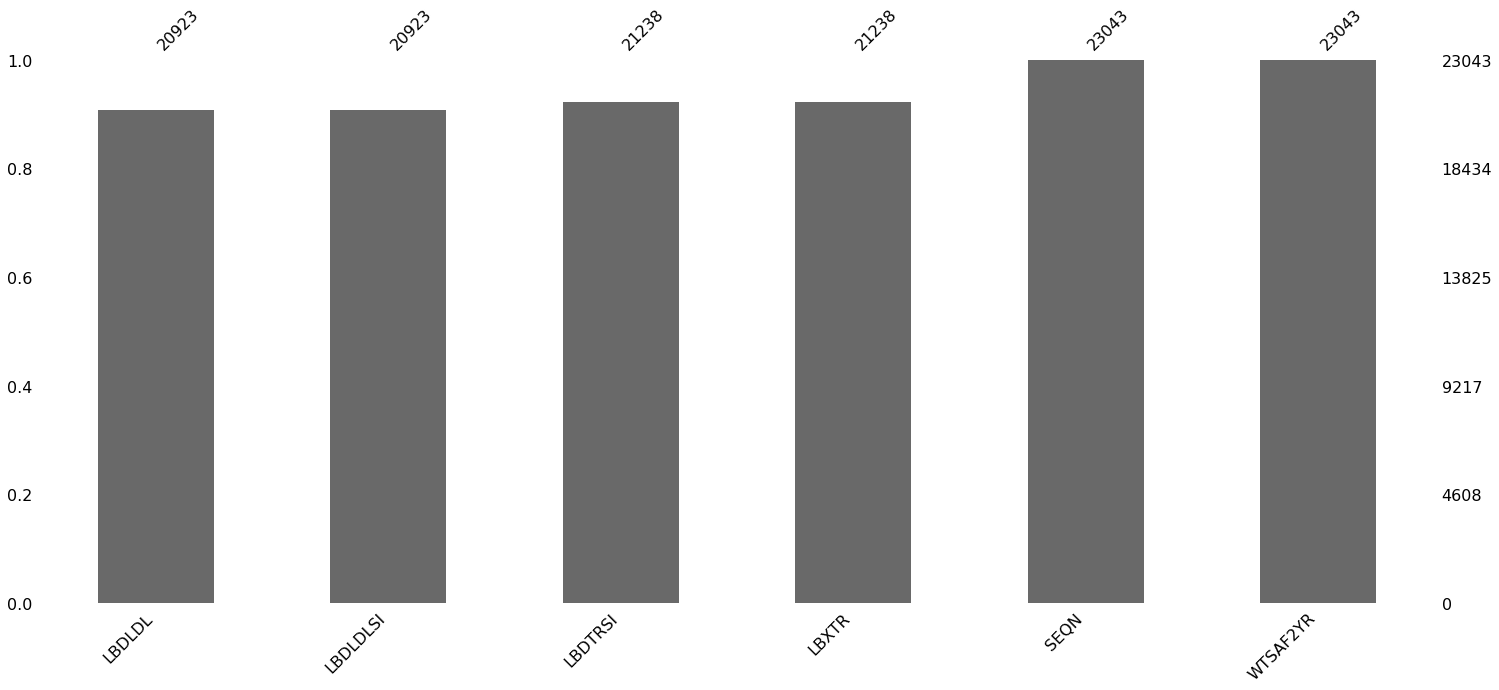

In [29]:
msno.bar(cholesterol_LDL)

In [30]:
cholesterol_LDL_new_cols = {'SEQN':'SEQN',
                       'WTSAF2YR':'Fasting subsample 2 year MEC weight',
                       'LBXTR':'Triglyceride (mg/dL)',
                       'LBDTRSI':'Triglyceride (mmol/L)',
                       'LBDLDLSI':'LDL-cholesterol (mmol/L)',
                       'LBDLDL':'LDL-cholesterol (mg/dL)'}

cholesterol_LDL = cholesterol_LDL.rename(columns = cholesterol_LDL_new_cols)
cholesterol_LDL.columns = cholesterol_LDL.columns.str.replace(' ','_')

In [31]:
vitamin_d = batch_read('/Users/jnl741/Desktop/NHANES/Lab_values/Vitamin_D')

In [32]:
vitamin_d.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36673 entries, 0 to 9164
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   LBDVD2LC  31099 non-null  float64
 1   LBDVD3LC  31101 non-null  float64
 2   LBDVE3LC  30848 non-null  float64
 3   LBDVIDLC  31098 non-null  float64
 4   LBXVD2MS  31099 non-null  float64
 5   LBXVD3MS  31101 non-null  float64
 6   LBXVE3MS  30848 non-null  float64
 7   LBXVIDMS  31098 non-null  float64
 8   SEQN      36673 non-null  float64
dtypes: float64(9)
memory usage: 2.8 MB


In [33]:
vitamin_d_2015 = pd.read_sas('/Users/jnl741/Desktop/VID_D.XPT')

<AxesSubplot:>

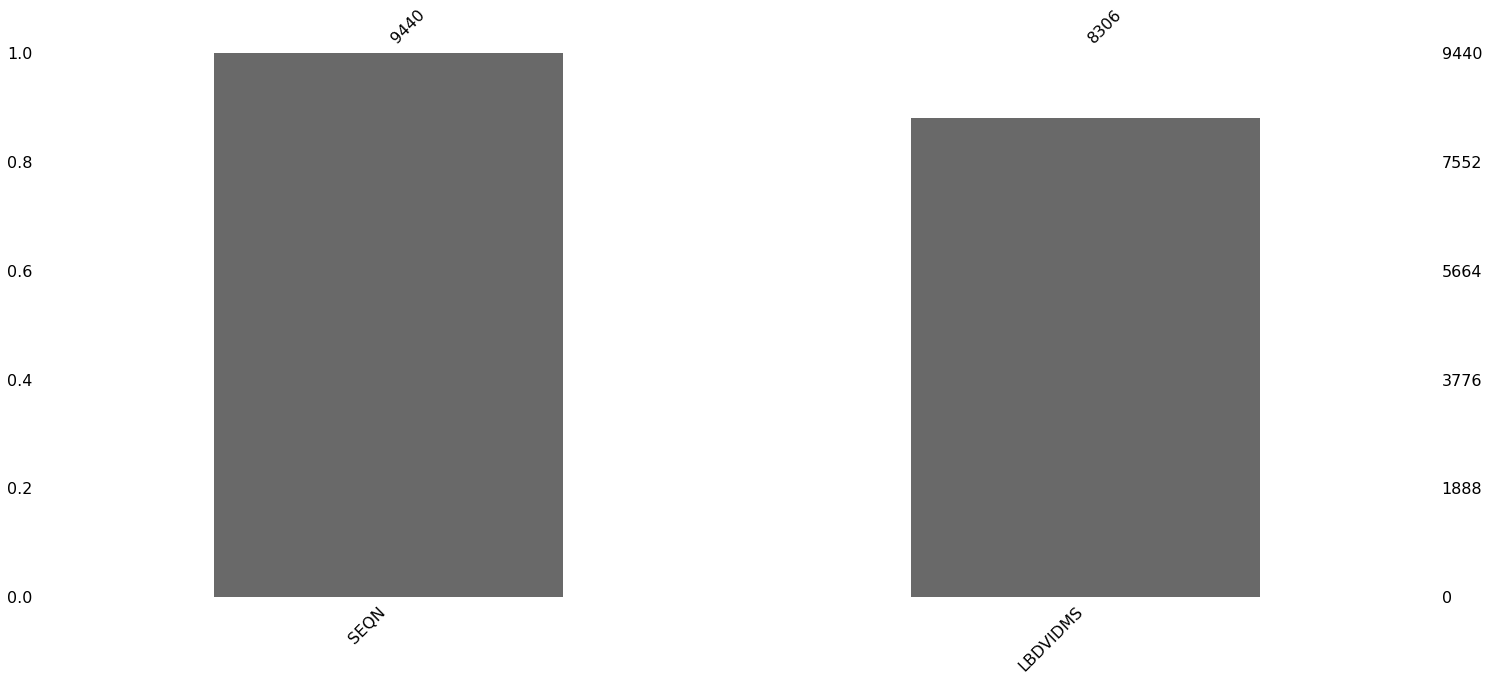

In [34]:
msno.bar(vitamin_d_2015)

In [35]:
vitamin_d_2015 = vitamin_d_2015.rename(columns = {'LBDVIDMS':'LBXVIDMS'})

In [36]:
vitamin_d_master = pd.concat([vitamin_d_2015,vitamin_d])

<AxesSubplot:>

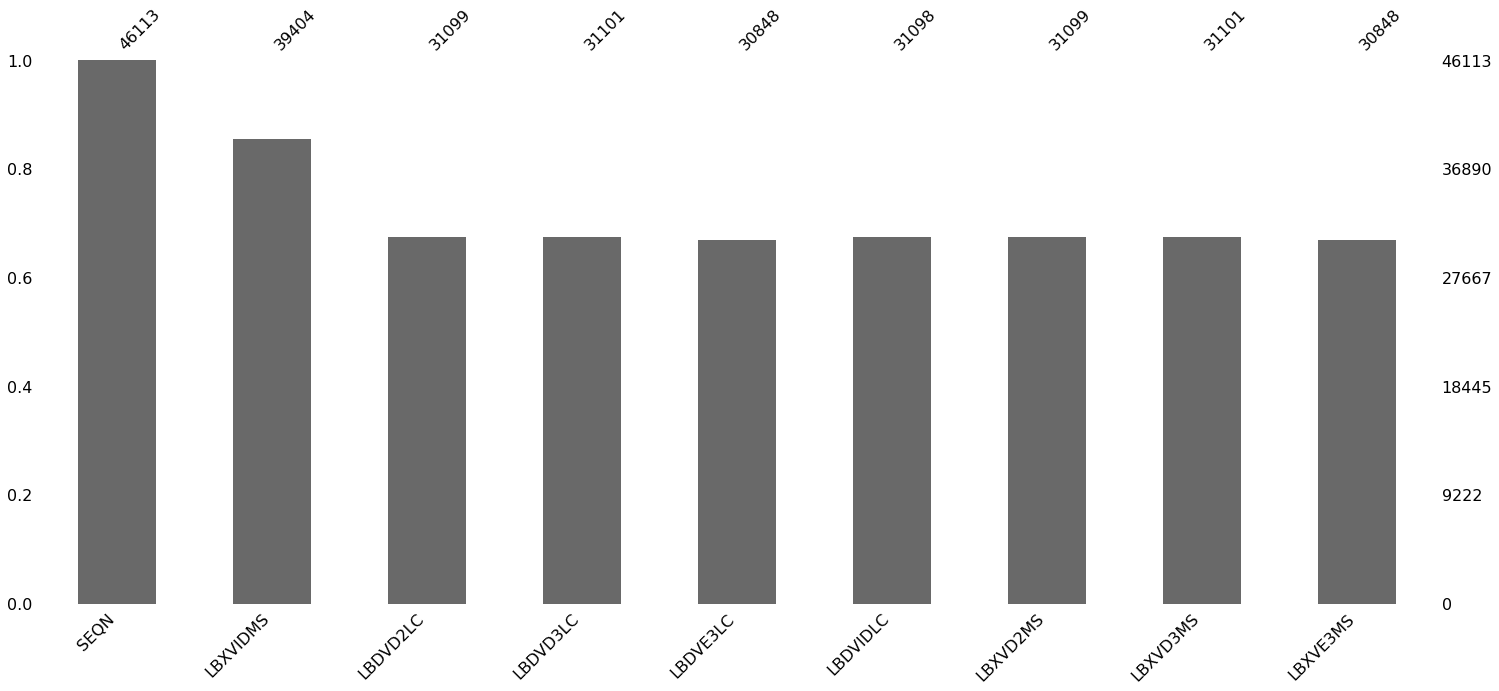

In [37]:
msno.bar(vitamin_d_master)

In [38]:
vitamin_d_master = vitamin_d[["SEQN","LBXVIDMS","LBXVD2MS","LBXVD3MS","LBXVE3MS"]].copy()

vitamin_d_master = vitamin_d_master.rename(columns = {'LBXVIDMS':'Vitamin_d_total_(nmol/L)',
                                  "LBXVD2MS":"Vitamin_D2_(nmol/L)",
                                  "LBXVD3MS":"Vitamin_D3_(nmol/L)",
                                  "LBXVE3MS":"epi-25OHD3_(nmol/L)"})

vitamin_d_master.columns = vitamin_d_master.columns.str.replace(' ','_')

In [39]:
"""As the total column is the sum of 25OHD2 and 3 columns, the missing values in the total column should only
exist if one of the others (or both) is null, as well."""

vitamin_d_master[(vitamin_d_master['Vitamin_d_total_(nmol/L)'].isnull()) & (vitamin_d_master['Vitamin_D2_(nmol/L)'].notnull()) | (vitamin_d_master['Vitamin_D3_(nmol/L)'].notnull())]

SEQN  Vitamin_d_total_(nmol/L)  Vitamin_D2_(nmol/L)  \
0     41475.0                      58.8                 1.45   
1     41476.0                      80.9                 1.45   
2     41477.0                      81.8                 1.45   
4     41479.0                      78.4                 1.45   
7     41482.0                      61.9                 3.71   
...       ...                       ...                  ...   
9160  93698.0                      58.2                 1.45   
9161  93699.0                      75.2                 2.51   
9162  93700.0                      66.2                 1.45   
9163  93701.0                      72.2                 1.45   
9164  93702.0                      65.8                 1.45   

      Vitamin_D3_(nmol/L)  epi-25OHD3_(nmol/L)  
0                    57.3                 4.17  
1                    79.4                 5.52  
2                    80.3                 2.42  
4                    76.9                 3.07  
7                    58.2                 3.10  
...                   ...                  ...  
9160                 56.8                 4.87  
9161                 72.7                 9.38  
9162                 64.8                 4.15  
9163                 70.8                 7.13  
9164                 64.4                 5.41  

[31102 rows x 5 columns]

<AxesSubplot:>

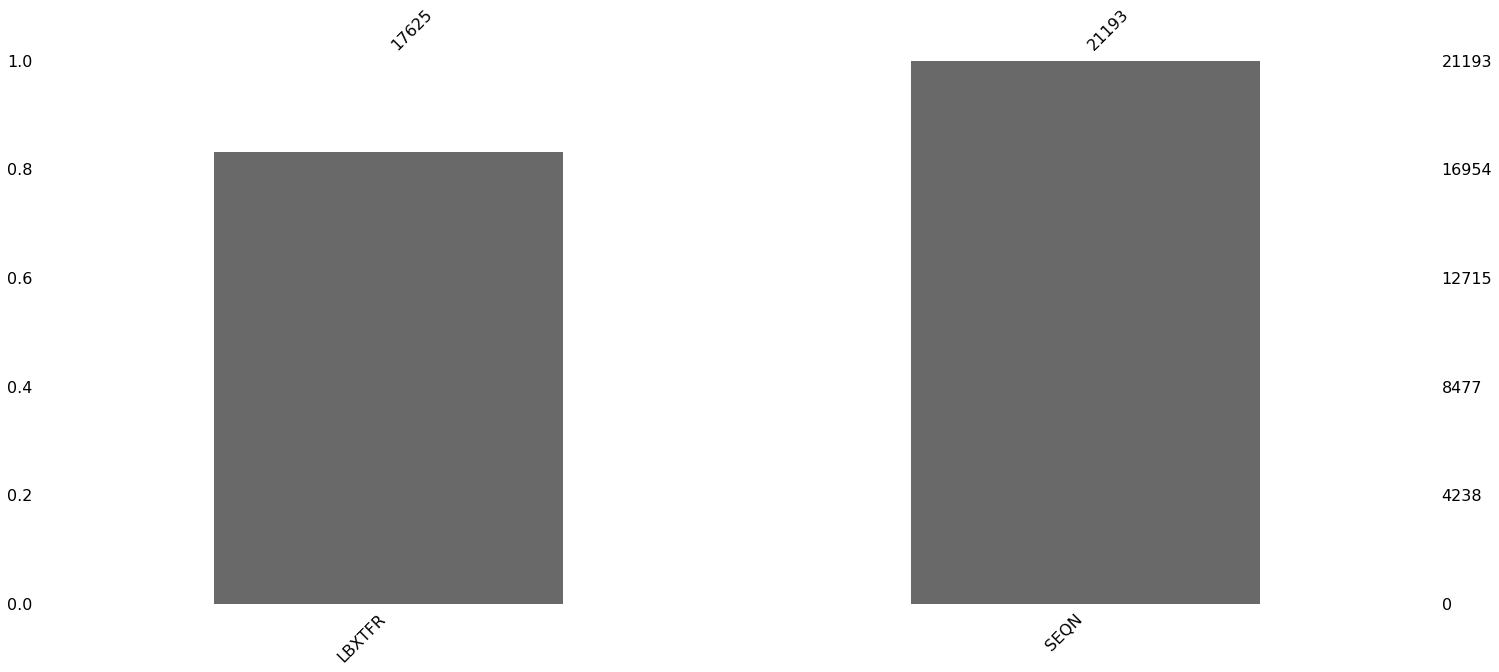

In [40]:
transferrin = batch_read('/Users/jnl741/Desktop/NHANES/Lab_values/Transferrin')
msno.bar(transferrin)

In [41]:
transferrin = transferrin.rename(columns = {'LBXTFR':'Transferrin_receptor_(mg/L)'})
transferrin.columns = transferrin.columns.str.replace(' ','_')

<AxesSubplot:>

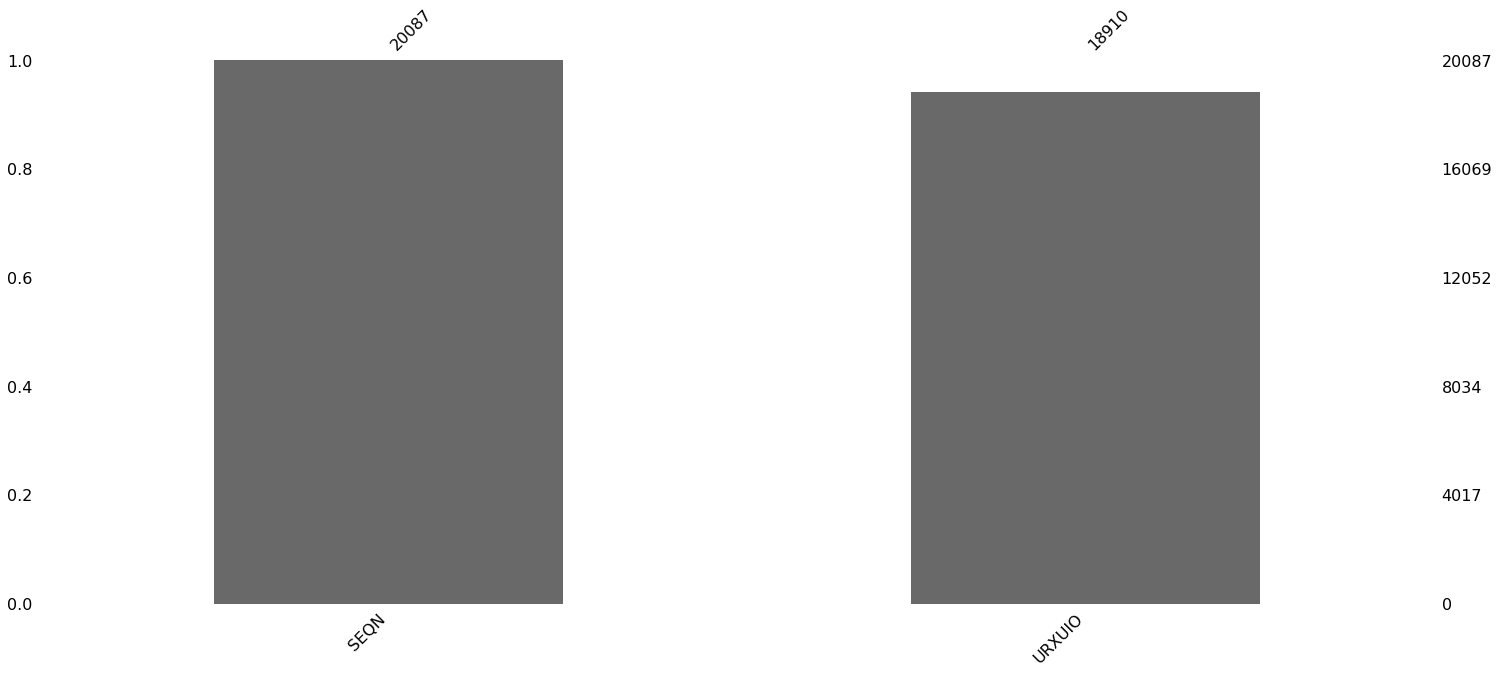

In [42]:
iodine = batch_read('/Users/jnl741/Desktop/NHANES/Lab_values/Iodine')
msno.bar(iodine)

In [43]:
iodine = iodine.rename(columns = {'URXUIO':'Iodine_urine_(ug/L)'})

<AxesSubplot:>

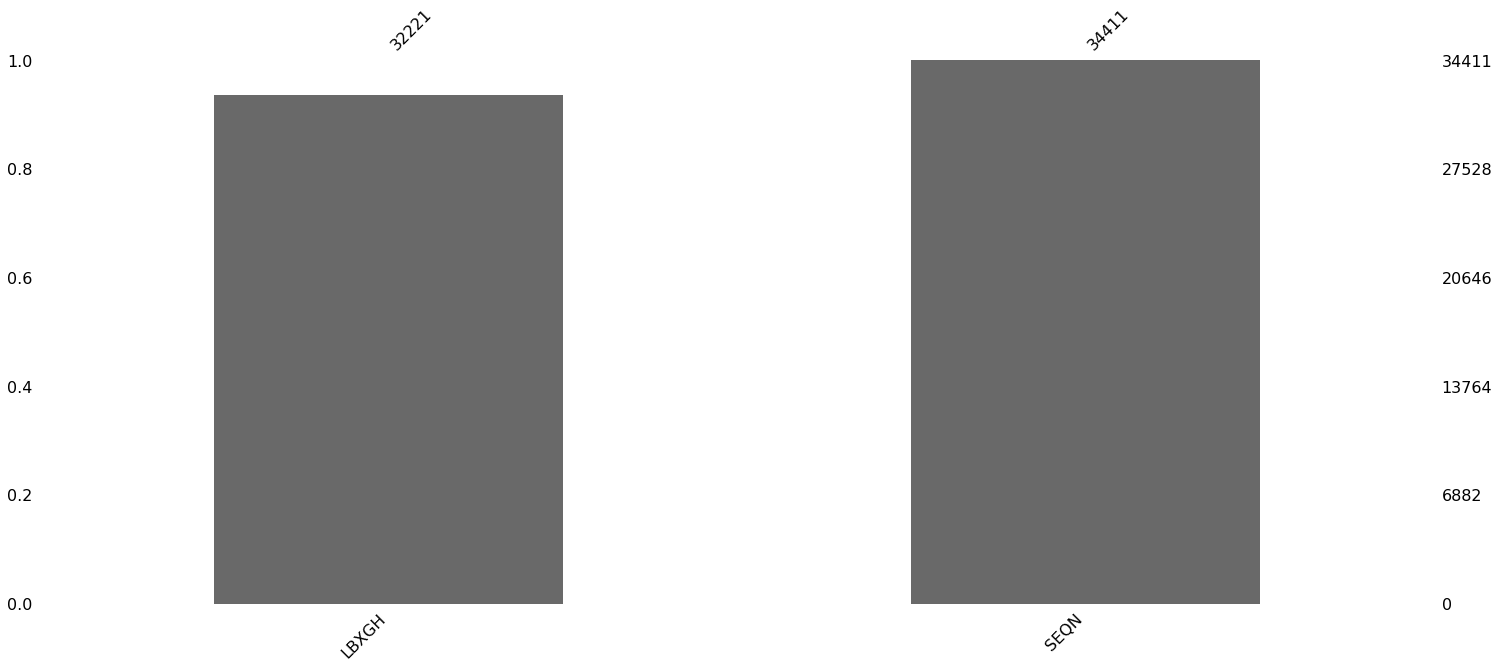

In [44]:
glycohemoglobin = batch_read('/Users/jnl741/Desktop/NHANES/Lab_values/Glycohemoglobin')
msno.bar(glycohemoglobin)

In [45]:
glycohemoglobin = glycohemoglobin.rename(columns = {'LBXGH':'Glycohemoglobin_(%)'})


<AxesSubplot:>

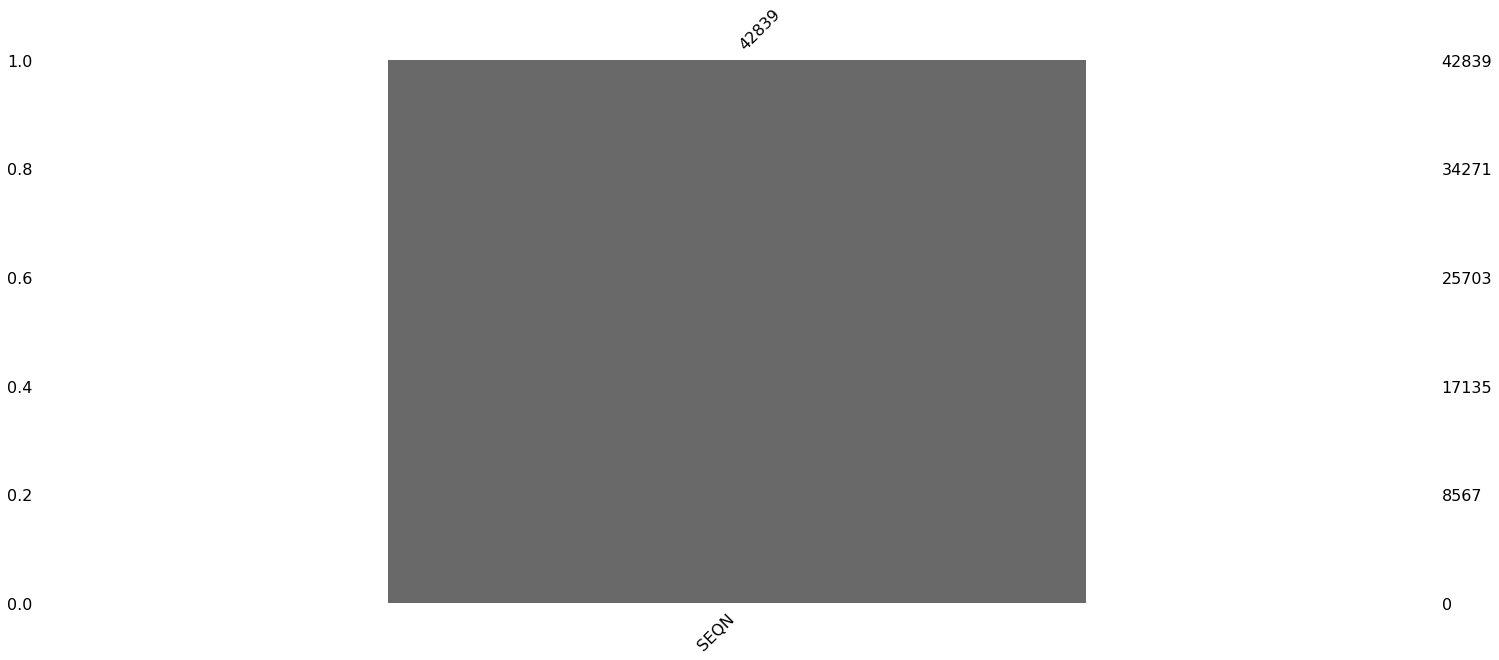

In [46]:
folate_RBCs = batch_read('/Users/jnl741/Desktop/NHANES/Lab_values/Folate_RBC_serum')
msno.bar(folate_RBCs)

In [47]:
folate_0506 = pd.read_sas('/Users/jnl741/Desktop/NHANES/Lab_values/Folate_RBC_serum/FOLATE_D.XPT')
folate_0708 = pd.read_sas('/Users/jnl741/Desktop/NHANES/Lab_values/Folate_RBC_serum/FOLATE_E.XPT')
folate_0910 = pd.read_sas('/Users/jnl741/Desktop/NHANES/Lab_values/Folate_RBC_serum/FOLATE_F.XPT')
folate_1516 = pd.read_sas('/Users/jnl741/Desktop/NHANES/Lab_values/Folate_RBC_serum/FOLATE_I.XPT')
folate_1718 = pd.read_sas('/Users/jnl741/Desktop/NHANES/Lab_values/Folate_RBC_serum/FOLATE_J.XPT')

In [48]:
folate_0506 = folate_0506.rename(columns = {'LBXRBF':'RBC Folate (ng/mL)',
                                            'LBDRBFSI':'RBC Folate (nmol/L)'})
folate_0506 = folate_0506.drop(columns = ['LBXFOL','LBDFOLSI'])

In [49]:
folate_0708 = folate_0708.rename(columns = {'LBDRBF':'RBC Folate (ng/mL)',
                                            'LBXRBFSI':'RBC Folate (nmol/L)'})
folate_0708 = folate_0708.drop(columns = ['LBDFOL','LBXFOLSI'])

In [50]:
folate_0910 = folate_0910.rename(columns = {'LBDRBF':'RBC Folate (ng/mL)',
                                 'LBXRBFSI':'RBC Folate (nmol/L)'})
folate_0910 = folate_0910.drop(columns = ['LBDFOL','LBXFOLSI'])

In [51]:
folate_1516 = folate_1516.rename(columns = {'LBDRFO':'RBC Folate (ng/mL)',
                              'LBDRFOSI':'RBC Folate (nmol/L)'})

In [52]:
folate_1718 = folate_1718.rename(columns = {'LBDRFO':'RBC Folate (ng/mL)',
                              'LBDRFOSI':'RBC Folate (nmol/L)'})
folate_1718 = folate_1718.drop(columns = ['WTFOL2YR'])

In [53]:
folate_master = pd.concat([folate_0506,
                          folate_0708,
                          folate_0910,
                          folate_1516,
                          folate_1718])

folate_master.columns = folate_master.columns.str.replace(' ','_')

<AxesSubplot:>

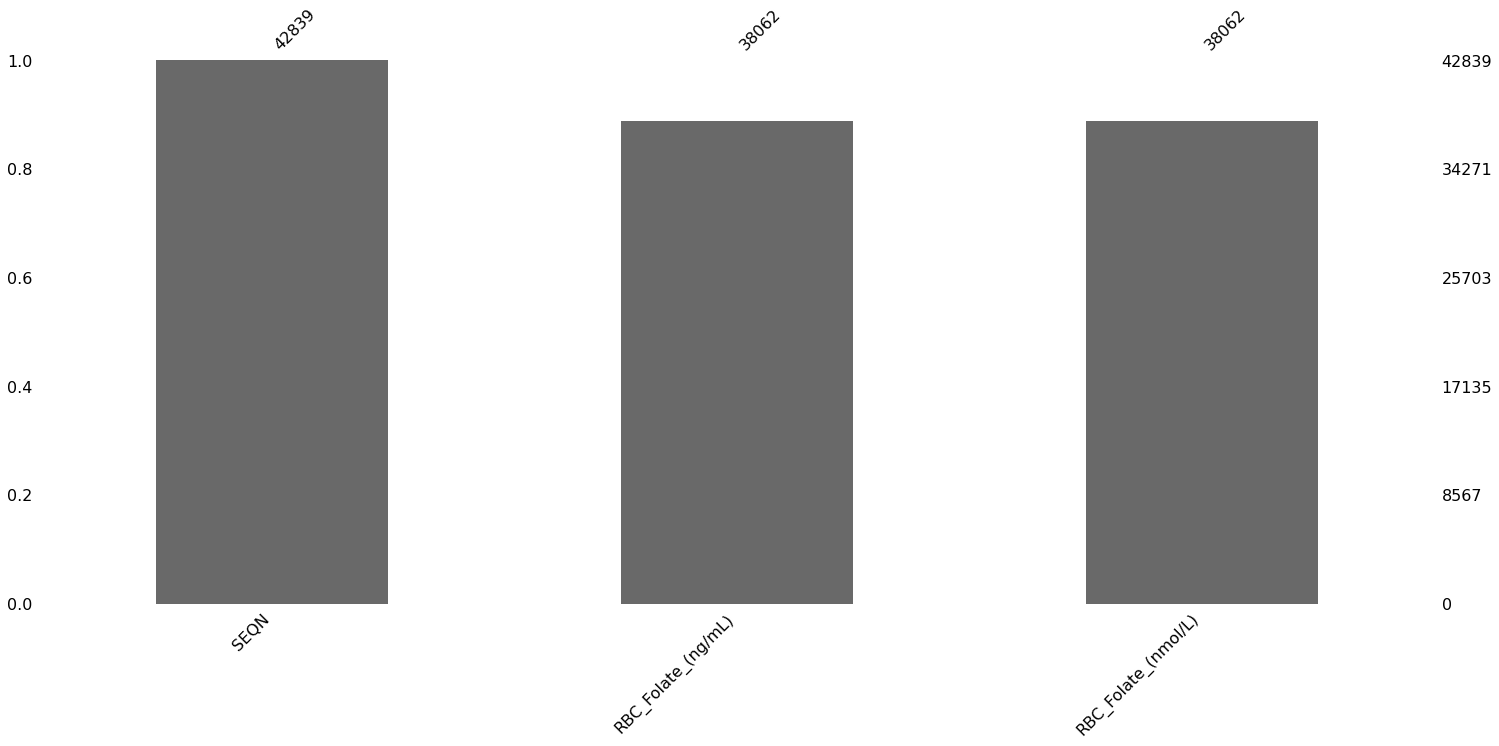

In [54]:
msno.bar(folate_master)

In [55]:
ferritin = batch_read('/Users/jnl741/Desktop/NHANES/Lab_values/Ferritin')


<AxesSubplot:>

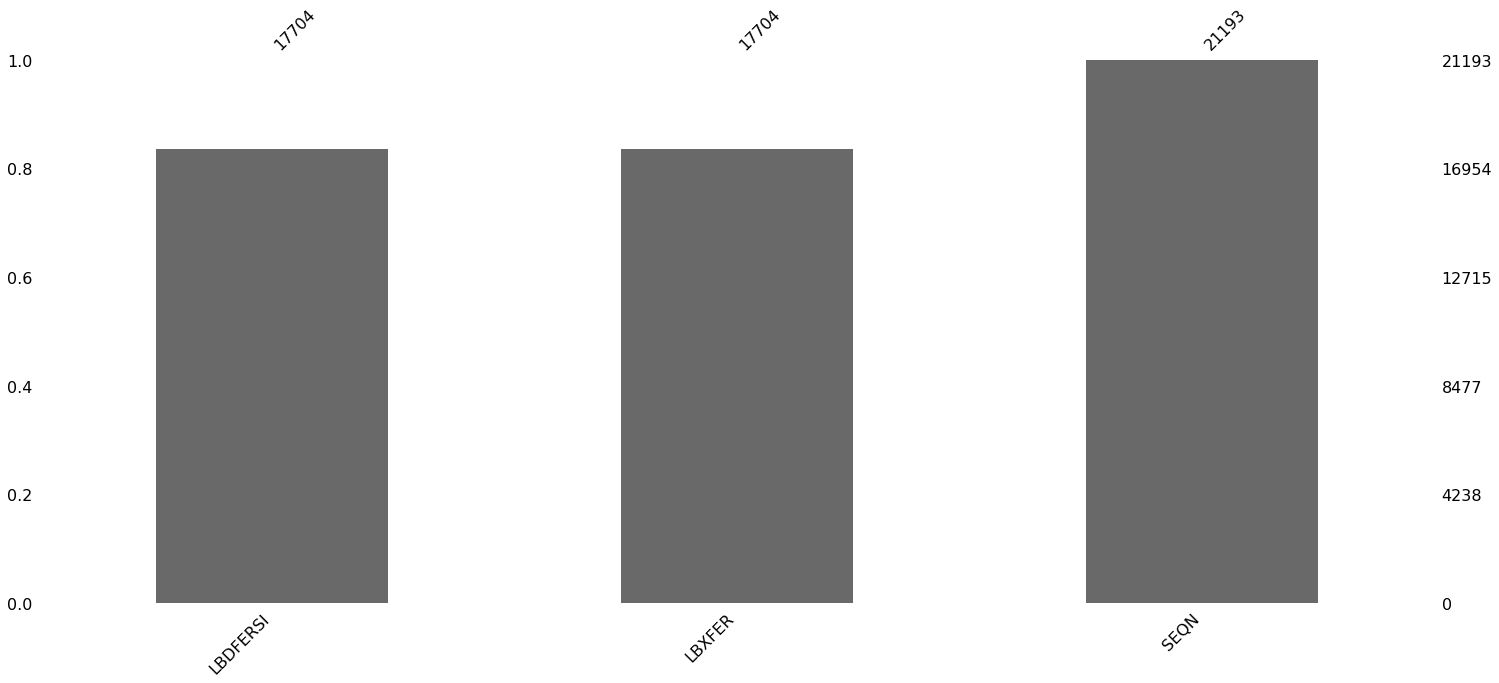

In [56]:
msno.bar(ferritin)

In [57]:
ferritin = ferritin.rename(columns = {'LBXFER':'Ferritin (ng/mL)',
                                      'LBDFERSI':'Ferritin (ug/L)'})


<AxesSubplot:>

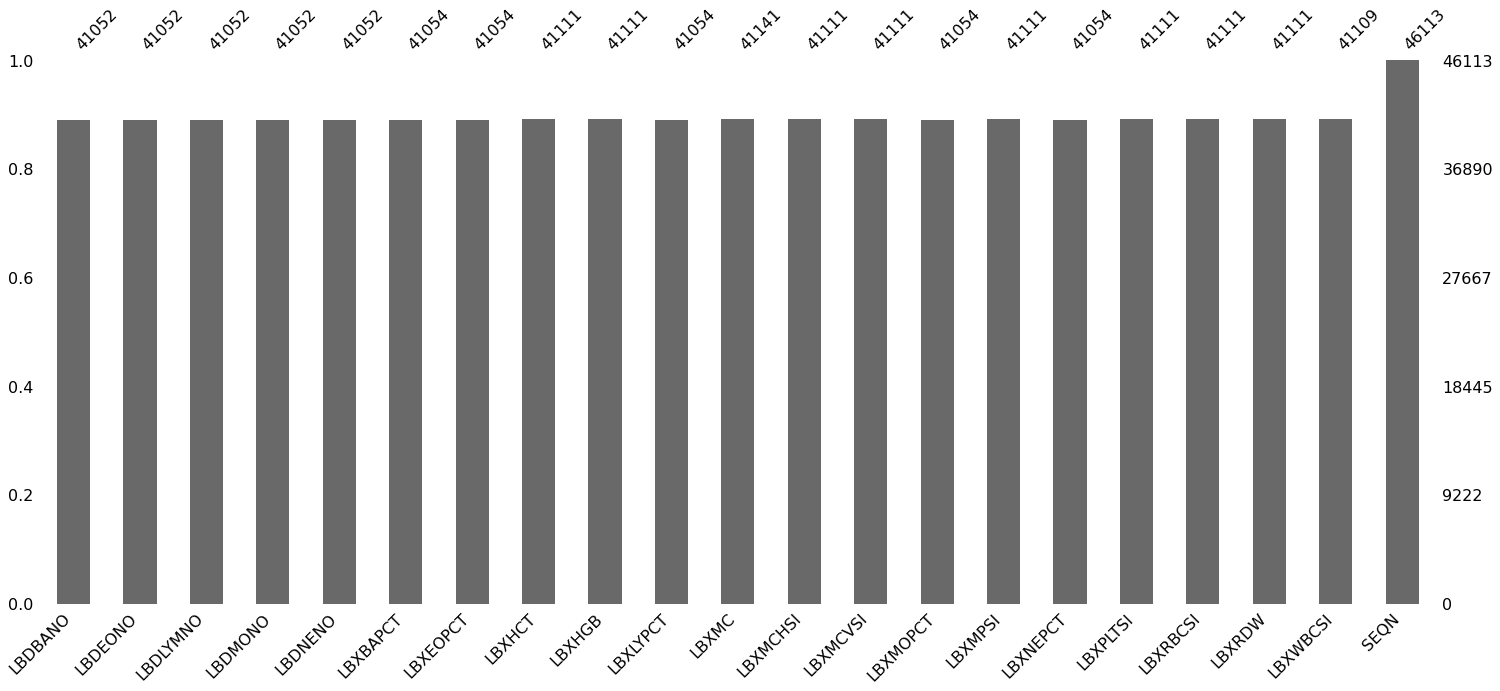

In [58]:
blood_count = batch_read('/Users/jnl741/Desktop/NHANES/Lab_values/Blood_count')
msno.bar(blood_count)

In [59]:
blood_count_new_cols = {
'LBXWBCSI':'White blood cell count (1000 cells/uL)',
'LBXLYPCT':'Lymphocyte percent',
'LBXMOPCT':'Monocyte percent',
'LBXNEPCT':'Segmented neutrophils percent',
'LBXEOPCT':'Eosinophils percent',
'LBXBAPCT':'Basophils percent',
'LBDLYMNO':'Lymphocyte number (1000 cells/uL)',
'LBDMONO':'Monocyte number (1000 cells/uL)',
'LBDNENO':'Segmented neutrophils num (1000 cell/uL)',
'LBDEONO':'Eosinophils number (1000 cells/uL)',
'LBDBANO':'Basophils number (1000 cells/uL)',
'LBXRBCSI':'Red blood cell count (million cells/uL)',
'LBXHGB':'Hemoglobin (g/dL)',
'LBXHCT':'Hematocrit',
'LBXMCVSI':'Mean cell volume (fL)',
'LBXMCHSI':'Mean cell hemoglobin (pg)',
'LBXMC':'MCHC (g/dL)',
'LBXRDW':'Red cell distribution width (%)',
'LBXPLTSI':'Platelet count SI (1000 cells/uL)',
'LBXMPSI':'Mean platelet volume (fL)'
}

In [60]:
blood_count = blood_count.rename(columns = blood_count_new_cols)
blood_count.columns = blood_count.columns.str.replace(' ','_')

<AxesSubplot:>

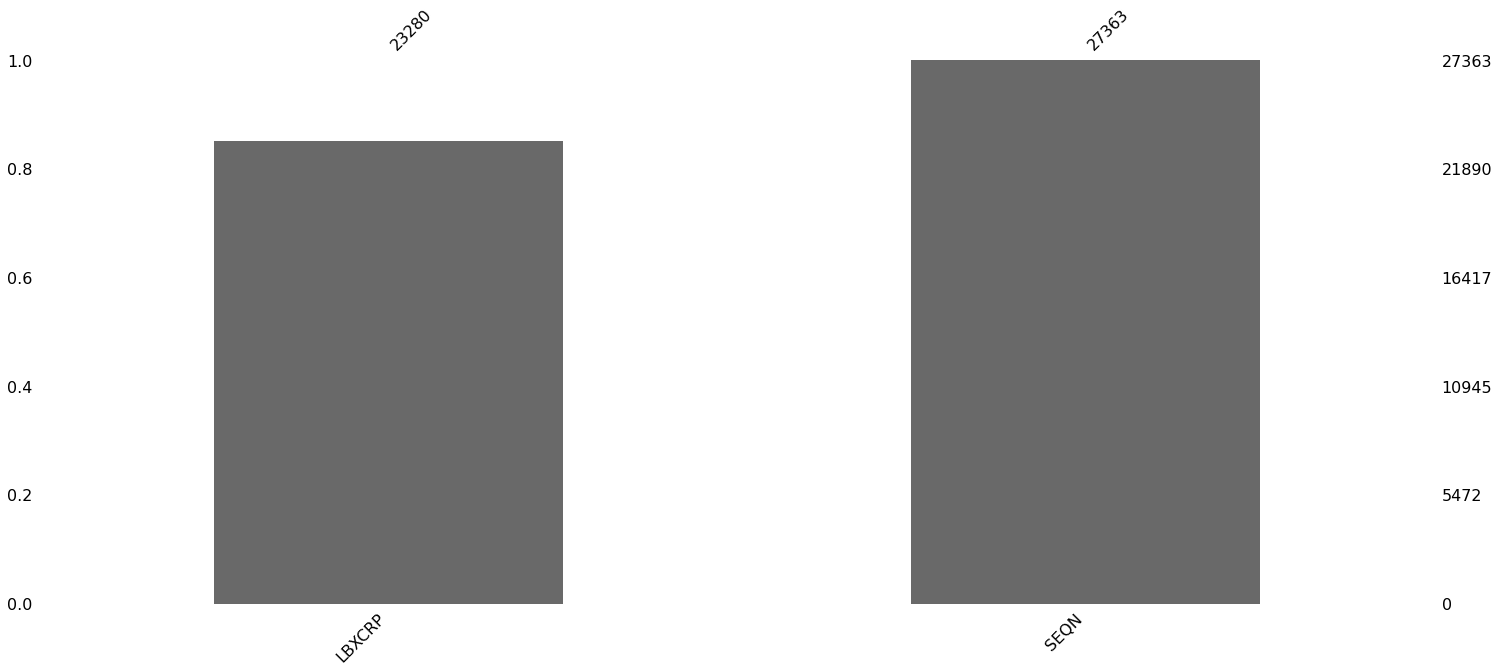

In [61]:
c_reactive = batch_read('/Users/jnl741/Desktop/NHANES/Lab_values/C-reactive_protein')
msno.bar(c_reactive)

In [62]:
c_reactive = c_reactive.rename(columns = {'LBXCRP':'C-reactive_protein(mg/dL)'})

<AxesSubplot:>

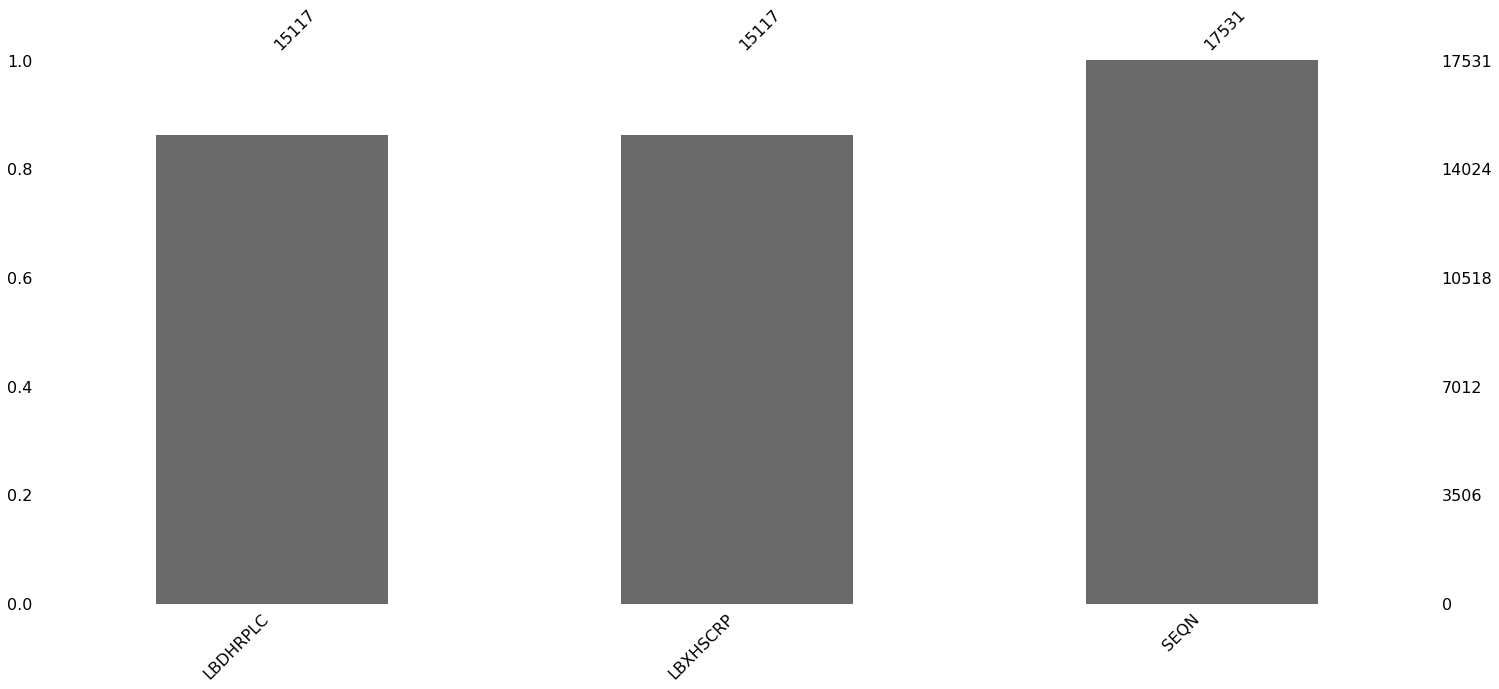

In [63]:
c_reactive_HS = batch_read('/Users/jnl741/Desktop/NHANES/Lab_values/CRP_High_sensitivity')
msno.bar(c_reactive_HS)

In [64]:
c_reactive_HS = c_reactive_HS.rename(columns = {'LBXHSCRP':'C-reactive_protein(mg/dL)'})
c_reactive_HS = c_reactive_HS.drop(columns = ['LBDHRPLC'])

In [65]:
c_reactive_master = pd.concat([c_reactive, c_reactive_HS])
c_reactive_master.shape

(44894, 2)

In [395]:
"""Merge the individual dataframes into a master dataframe using an inner join on the 'SEQN' column"""

merged_nhanes = reduce(lambda x,y: pd.merge(x,y, on = 'SEQN', how = 'inner'),[depression_screen,
                                                                           demographics, 
                                                                           biochem_profile,
                                                                           c_reactive_master,
                                                                           blood_count,
                                                                           folate_master,
                                                                           glycohemoglobin,
                                                                           transferrin,
                                                                           vitamin_d_master])

In [396]:
merged_nhanes.shape

(7465, 66)

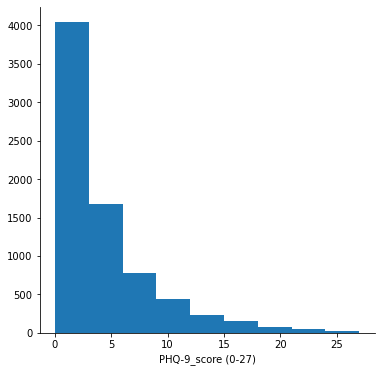

In [397]:
fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize = (6,6))
axs.hist(x = merged_nhanes['PHQ-9_score'],
        bins = [i for i in range(30) if i%3 == 0],
        )
axs.set_xlabel('PHQ-9_score (0-27)')

sns.despine();

In [398]:
merged_nhanes['Depression_rating'].value_counts()

Not depressed        5309
Mild                 1349
Moderate              358
Severe                295
Moderately severe     154
Name: Depression_rating, dtype: int64

In [399]:
'''Replace spaces in column names with _'''
merged_nhanes.columns = merged_nhanes.columns.str.replace(' ','_')

In [400]:
pd.options.display.max_rows = 100
merged_nhanes.dtypes

Have_little_interest_in_doing_things        float64
Feeling_down_depressed_or_hopeless          float64
Sleeping_issues                             float64
Feeling_tired_or_low_energy                 float64
Poor_appetite_or_overeating                 float64
Feeling_bad_about_self                      float64
Trouble_coencentrating                      float64
Moving_or_speaking_too_slow_or_fast         float64
Thought_you_would_be_better_of_dead         float64
SEQN                                        float64
PHQ-9_score                                 float64
Depression_rating                            object
Age_in_years                                float64
Gender                                      float64
Race/ethnicity                              float64
Blood_urea_nitrogen_(mmol/L)                float64
Globulin_(g/L)                              float64
Glucose_(mmol/L)                            float64
Phosphorus_(mmol/L)                         float64
Bilirubin_(u

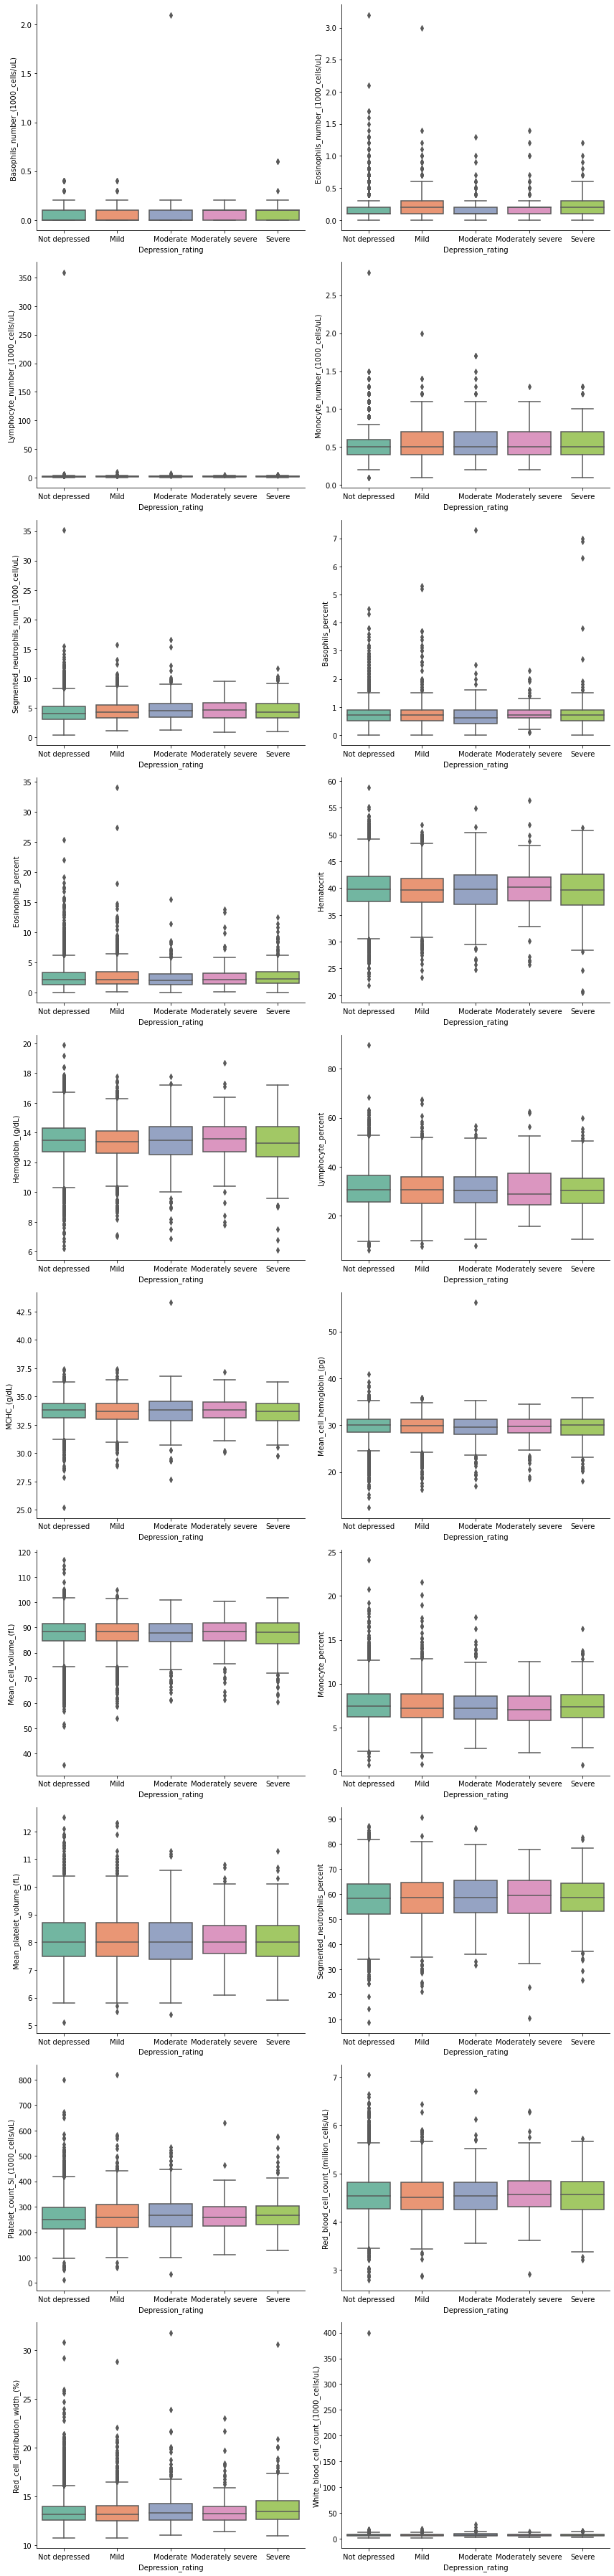

In [404]:
"""Plot blood count variables as function of depression severity"""

fig, axs = plt.subplots(nrows = 10, ncols = 2,figsize = (12,50))

for col, ax in zip(merged_nhanes[blood_count.columns].columns, axs.ravel()):
    sns.boxplot(y = col, 
                x = merged_nhanes['Depression_rating'], 
                  data = merged_nhanes,
                  ax = ax,
                 palette = 'Set2',
                order =['Not depressed','Mild','Moderate','Moderately severe','Severe'] )
    sns.despine()
plt.tight_layout();

In [390]:
"""Function to divide dataframe by outliers"""

def find_outliers(df, col, num_std_dev):
    threshold = np.mean(df[col]) + num_std_dev * merged_nhanes[col].std()
    
    return df[df[col] > threshold]

In [394]:
"""Isolate outliers in various blood markers"""
find_outliers(merged_nhanes, 'Basophils_number_(1000_cells/uL)', 4)[blood_count.columns]

Basophils_number_(1000_cells/uL)  Eosinophils_number_(1000_cells/uL)  \
264                                0.3                        7.000000e-01   
1404                               0.3                        4.000000e-01   
1520                               0.3                        2.000000e-01   
1541                               0.4                        1.000000e-01   
1569                               0.4                        3.000000e-01   
1898                               0.3                        4.000000e-01   
2496                               0.4                        2.000000e-01   
2600                               0.3                        1.000000e-01   
2620                               0.3                        3.000000e-01   
3133                               0.4                        1.000000e-01   
3187                               0.3                        2.000000e-01   
3371                               0.3                        5.397605e-79   
3434                               0.3                        5.000000e-01   
3446                               0.6                        3.000000e-01   
3475                               0.4                        2.000000e-01   
3488                               0.4                        2.000000e-01   
3889                               0.4                        2.000000e-01   
3919                               0.6                        2.000000e-01   
3962                               2.1                        3.000000e-01   
3987                               0.3                        2.000000e-01   
4222                               0.4                        1.000000e-01   
5127                               0.3                        4.000000e-01   

      Lymphocyte_number_(1000_cells/uL)  Monocyte_number_(1000_cells/uL)  \
264                                 3.7                              0.6   
1404                                2.7                              0.4   
1520                                1.7                              0.5   
1541                                1.1                              0.2   
1569                                3.5                              0.5   
1898                                2.9                              0.4   
2496                                2.1                              0.5   
2600                                3.6                              0.3   
2620                                2.8                              0.5   
3133                                2.0                              0.5   
3187                                3.9                              0.3   
3371                                1.2                              0.3   
3434                                3.5                              0.5   
3446                                2.2                              0.5   
3475                                2.9                              0.3   
3488                                2.8                              0.5   
3889                                4.1                              0.4   
3919                                2.4                              0.5   
3962                                8.0                              1.7   
3987                                2.8                              0.5   
4222                                3.2                              0.6   
5127                                3.0                              1.3   

      Segmented_neutrophils_num_(1000_cell/uL)  Basophils_percent  \
264                                        4.3                2.8   
1404                                       6.0                2.8   
1520                                       8.8                2.7   
1541                                       6.1                4.5   
1569                                       2.2                5.2   
1898                                       4.3  

In [409]:
pd.options.display.max_columns = 100
find_outliers(merged_nhanes, 'Lymphocyte_number_(1000_cells/uL)', 1)[blood_count.columns]

Basophils_number_(1000_cells/uL)  Eosinophils_number_(1000_cells/uL)  \
1337                               0.1                                 0.2   
3962                               2.1                                 0.3   
6074                               0.1                                 0.5   
7285                               0.4                                 3.2   

      Lymphocyte_number_(1000_cells/uL)  Monocyte_number_(1000_cells/uL)  \
1337                                6.6                              0.8   
3962                                8.0                              1.7   
6074                               10.6                              0.7   
7285                              358.8                              2.8   

      Segmented_neutrophils_num_(1000_cell/uL)  Basophils_percent  \
1337                                      11.3                0.4   
3962                                      16.6                7.3   
6074                                       3.9                0.4   
7285                                      35.2                0.1   

      Eosinophils_percent  Hematocrit  Hemoglobin_(g/dL)  Lymphocyte_percent  \
1337                  0.9        40.3               13.5                34.9   
3962                  1.0        38.4               12.5                28.0   
6074                  3.2        37.1               12.7                67.3   
7285                  0.8        30.4                9.0                89.7   

      MCHC_(g/dL)  Mean_cell_hemoglobin_(pg)  Mean_cell_volume_(fL)  \
1337         33.3                       30.0                   90.0   
3962         32.6                       23.9                   73.4   
6074         34.4                       31.0                   90.3   
7285         29.6                       25.5                   86.3   

      Monocyte_percent  Mean_platelet_volume_(fL)  \
1337               4.2                        8.8   
3962               5.9                        7.9   
6074               4.4                        7.7   
7285               0.7                        8.0   

      Segmented_neutrophils_percent  Platelet_count_SI_(1000_cells/uL)  \
1337                           59.7                              386.0   
3962                           57.8                              101.0   
6074                           24.9                              401.0   
7285                            8.8                              240.0   

      Red_blood_cell_count_(million_cells/uL)  \
1337                                     4.48   
3962                                     5.31   
6074                                     4.10   
7285                                     3.52   

      Red_cell_distribution_width_(%)  White_blood_cell_count_(1000_cells/uL)  \
1337                             12.4                                    19.0   
3962                             16.3                                    28.7   
6074                             13.3                                    15.8   
7285                             15.9                                   400.0   

          SEQN  
1337   93274.0  
3962   49314.0  
6074   98840.0  
7285  102389.0

In [411]:
find_outliers(merged_nhanes, 'White_blood_cell_count_(1000_cells/uL)', 3)[blood_count.columns]

Basophils_number_(1000_cells/uL)  Eosinophils_number_(1000_cells/uL)  \
3962                               2.1                                 0.3   
7285                               0.4                                 3.2   

      Lymphocyte_number_(1000_cells/uL)  Monocyte_number_(1000_cells/uL)  \
3962                                8.0                              1.7   
7285                              358.8                              2.8   

      Segmented_neutrophils_num_(1000_cell/uL)  Basophils_percent  \
3962                                      16.6                7.3   
7285                                      35.2                0.1   

      Eosinophils_percent  Hematocrit  Hemoglobin_(g/dL)  Lymphocyte_percent  \
3962                  1.0        38.4               12.5                28.0   
7285                  0.8        30.4                9.0                89.7   

      MCHC_(g/dL)  Mean_cell_hemoglobin_(pg)  Mean_cell_volume_(fL)  \
3962         32.6                       23.9                   73.4   
7285         29.6                       25.5                   86.3   

      Monocyte_percent  Mean_platelet_volume_(fL)  \
3962               5.9                        7.9   
7285               0.7                        8.0   

      Segmented_neutrophils_percent  Platelet_count_SI_(1000_cells/uL)  \
3962                           57.8                              101.0   
7285                            8.8                              240.0   

      Red_blood_cell_count_(million_cells/uL)  \
3962                                     5.31   
7285                                     3.52   

      Red_cell_distribution_width_(%)  White_blood_cell_count_(1000_cells/uL)  \
3962                             16.3                                    28.7   
7285                             15.9                                   400.0   

          SEQN  
3962   49314.0  
7285  102389.0

The outliers in particular categories (white blood cell count, basophils count, etc) appear to have abnormally high
levels of other cell types. We will therefore leave them in the dataset.

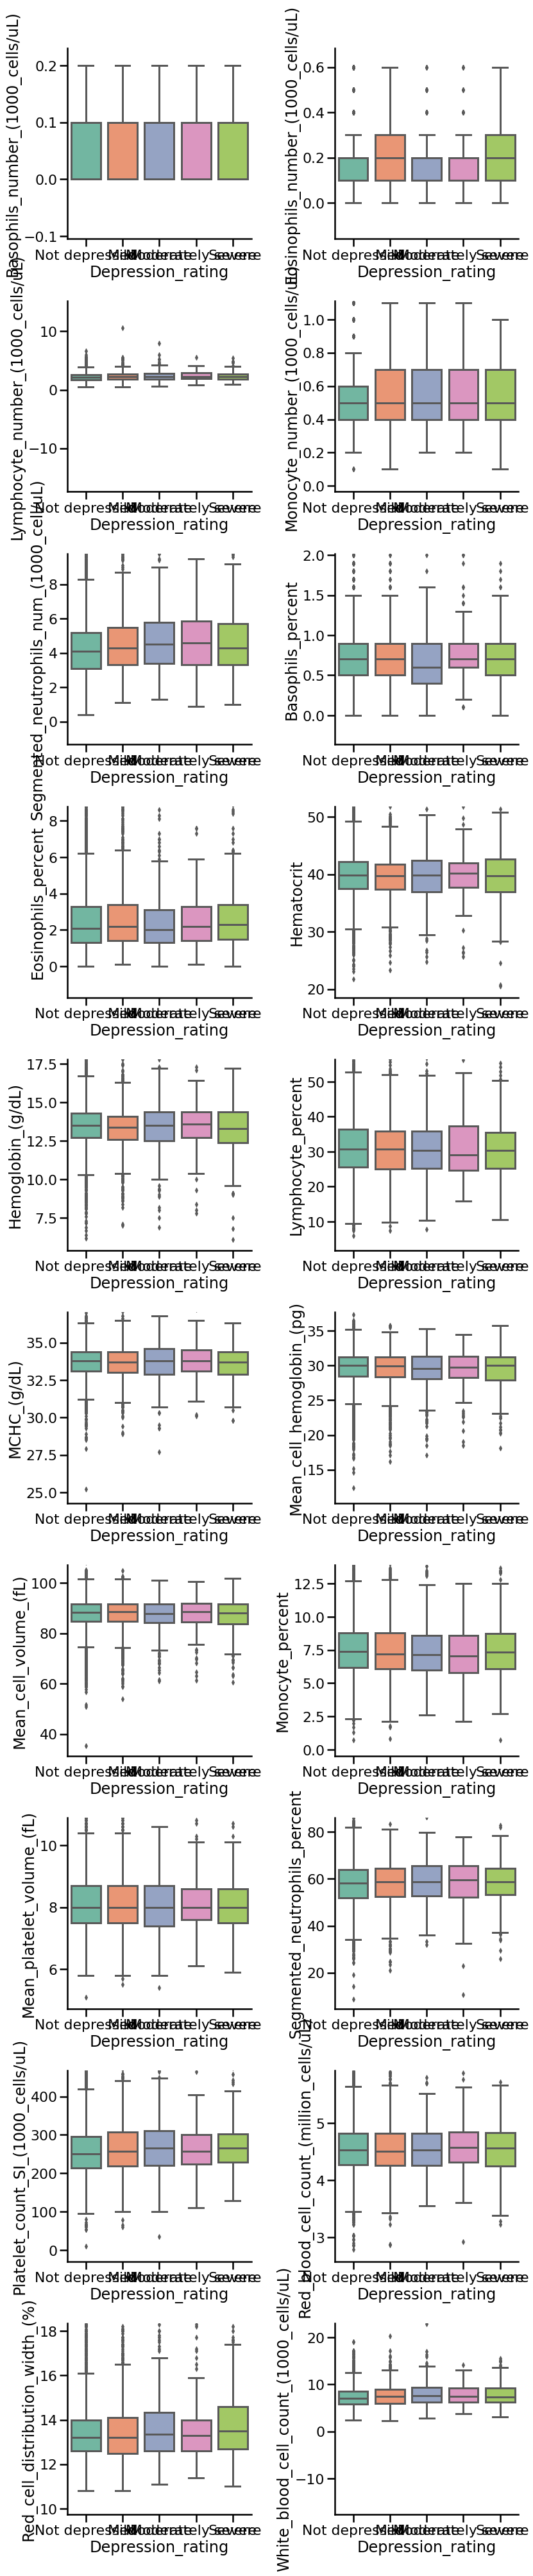

In [482]:
"""Plot blood count variables again but without points above 3 SD to avoid compression. """

fig, axs = plt.subplots(nrows = 10, ncols = 2,figsize = (12,55))

for col, ax in zip(merged_nhanes[blood_count.columns].columns, axs.ravel()):
    sns.boxplot(y = col, 
                x = merged_nhanes['Depression_rating'], 
                  data = merged_nhanes,
                  ax = ax,
                 palette = 'Set2',
                order =['Not depressed','Mild','Moderate','Moderately severe','Severe'] )
    y_lim = np.mean(merged_nhanes[col]) + 3*merged_nhanes[col].std()
    ax.set_ylim(top = y_lim)
    sns.despine()
plt.tight_layout();

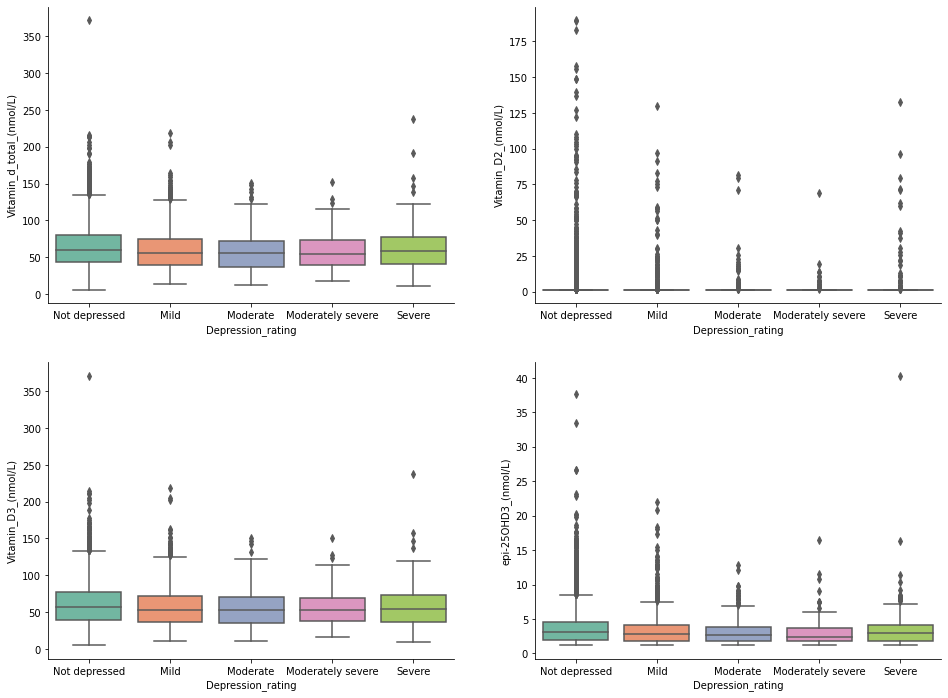

In [419]:
"""Plot vitamin D levels as function of depression severity"""

fig, axs = plt.subplots(nrows = 2, ncols = 2,figsize = (16,12))

for col, ax in zip(merged_nhanes[vitamin_d_master.columns[vitamin_d_master.columns != 'SEQN']], axs.ravel()):
    sns.boxplot(y = col, 
                x = merged_nhanes['Depression_rating'], 
                  data = merged_nhanes,
                  ax = ax,
                  palette = 'Set2',
               order =['Not depressed','Mild','Moderate','Moderately severe','Severe'] )
    sns.despine();

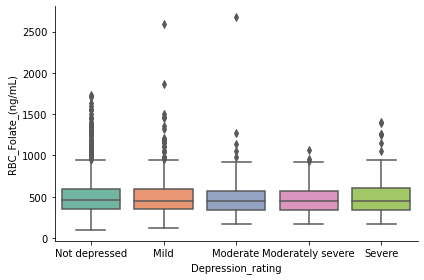

In [201]:
"""Folate as function of depression rating"""
fig, ax = plt.subplots(nrows = 1, ncols = 1,figsize = (6,4))


sns.boxplot(y = 'RBC_Folate_(ng/mL)', 
            x = 'Depression_rating', 
            data = merged_nhanes,
            ax = ax,
            palette = 'Set2',
            order = ['Not depressed','Mild','Moderate','Moderately severe','Severe'] )
    
sns.despine()
plt.tight_layout()

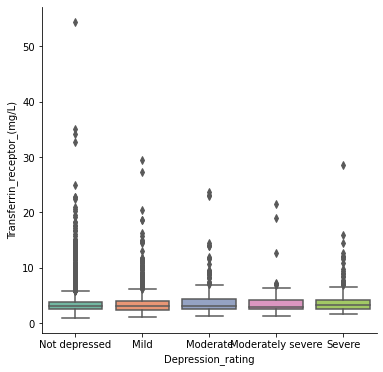

In [359]:
"""Transferrin as function of depression rating"""

fig, axs = plt.subplots(nrows = 1, ncols = 1,figsize = (6,6))
sns.boxplot(y = 'Transferrin_receptor_(mg/L)', 
            x = merged_nhanes['Depression_rating'], 
                  data = merged_nhanes,
                  palette = 'Set2',
               order =['Not depressed','Mild','Moderate','Moderately severe','Severe'] )
sns.despine()

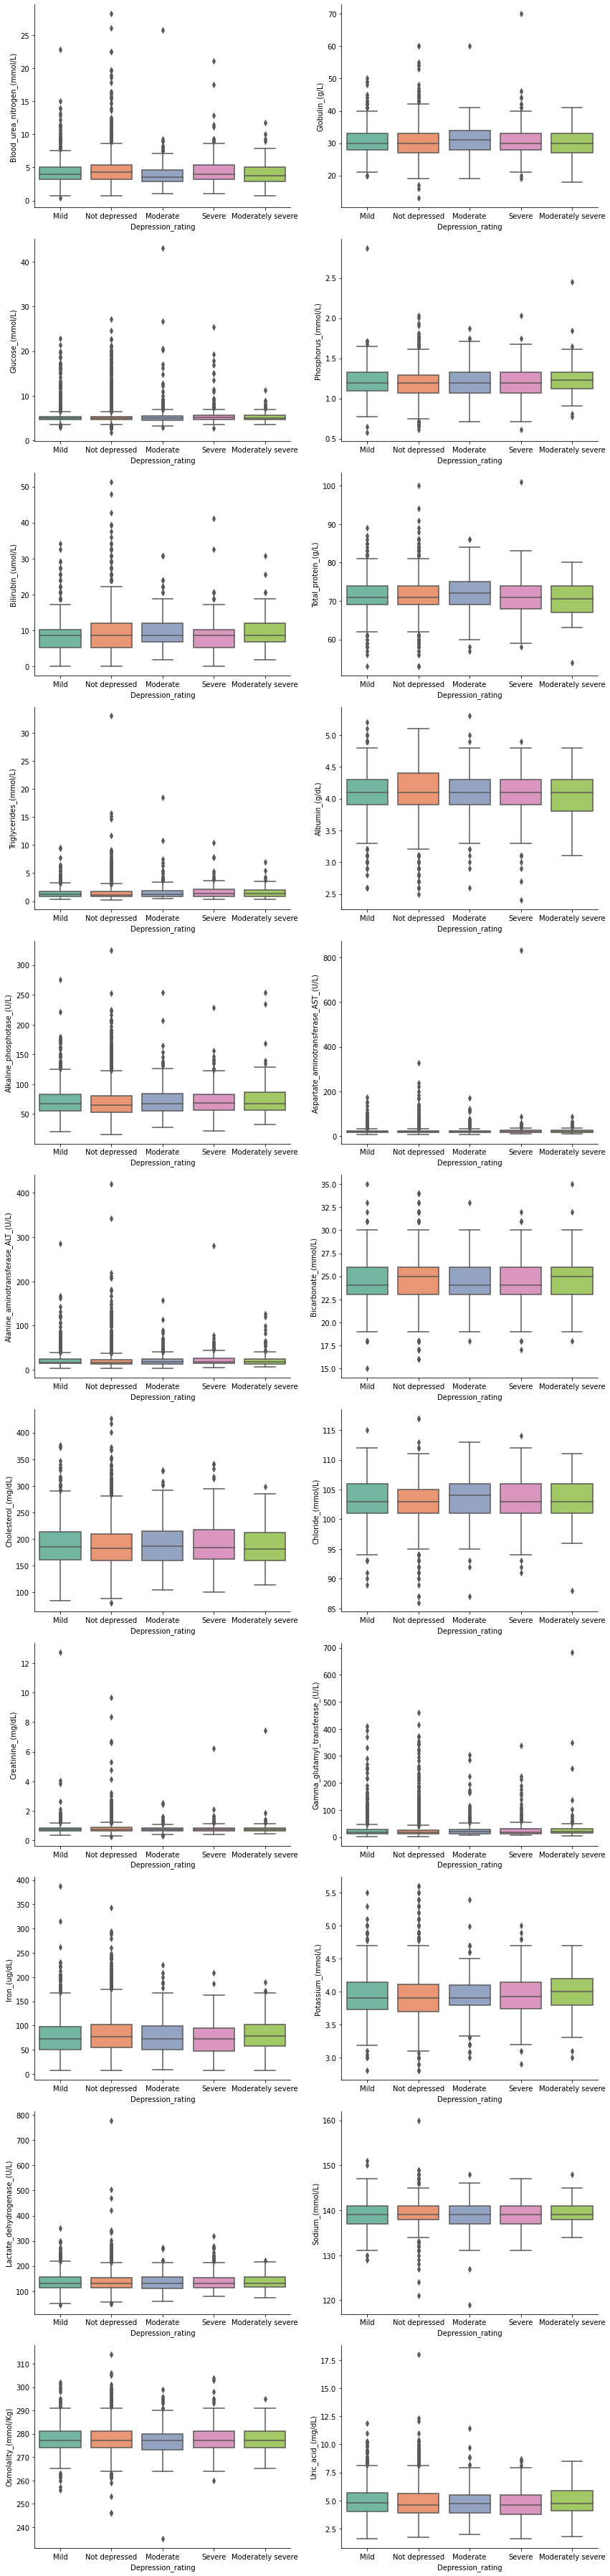

In [421]:
"""Biochemical markers as function of depression rating"""
fig, axs = plt.subplots(nrows = 11, ncols = 2,figsize = (12,50))

for col, ax in zip(merged_nhanes[biochem_profile.columns], axs.ravel()):
    sns.boxplot(y = col, 
                x = merged_nhanes['Depression_rating'], 
                  data = merged_nhanes,
                 palette = 'Set2',
                      ax = ax)
    y_lim = np.mean(merged_nhanes[col]) + 3*merged_nhanes[col].std()
    #ax.set_ylim(top = y_lim)
    sns.despine()
    
    
plt.tight_layout()

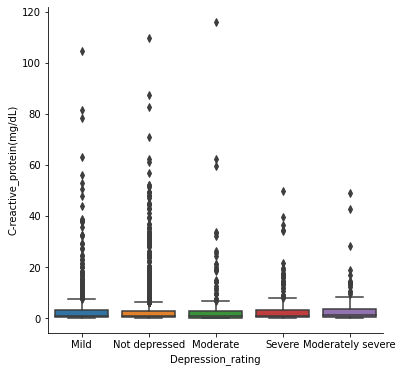

In [422]:
fig, axs = plt.subplots(nrows = 1, ncols = 1,figsize = (6,6))
sns.boxplot(y = 'C-reactive_protein(mg/dL)', 
            x = merged_nhanes['Depression_rating'], 
                  data = merged_nhanes)
#Restrict outliers to w/in 2 SD to avoid compression
y_lim = np.mean(merged_nhanes[col]) + 2*merged_nhanes[col].std()
#axs.set_ylim(top = y_lim)
sns.despine()

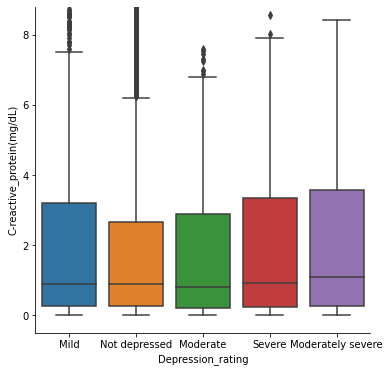

In [430]:
fig, axs = plt.subplots(nrows = 1, ncols = 1,figsize = (6,6))
sns.boxplot(y = 'C-reactive_protein(mg/dL)', 
            x = merged_nhanes['Depression_rating'], 
                  data = merged_nhanes)
#Restrict outliers to w/in 2 SD to avoid compression
y_lim = np.mean(merged_nhanes[col]) + 3*merged_nhanes[col].std()
axs.set_ylim(top = y_lim, bottom = -0.5)

sns.despine()

In [383]:
"""Split dataframe into 'Depressed' and 'Not depressed' dataframes."""

not_depressed = merged_nhanes[merged_nhanes['Depression_rating'] == 'Not depressed']
depressed = merged_nhanes[~(merged_nhanes['Depression_rating'] == 'Not depressed')]

<AxesSubplot:>

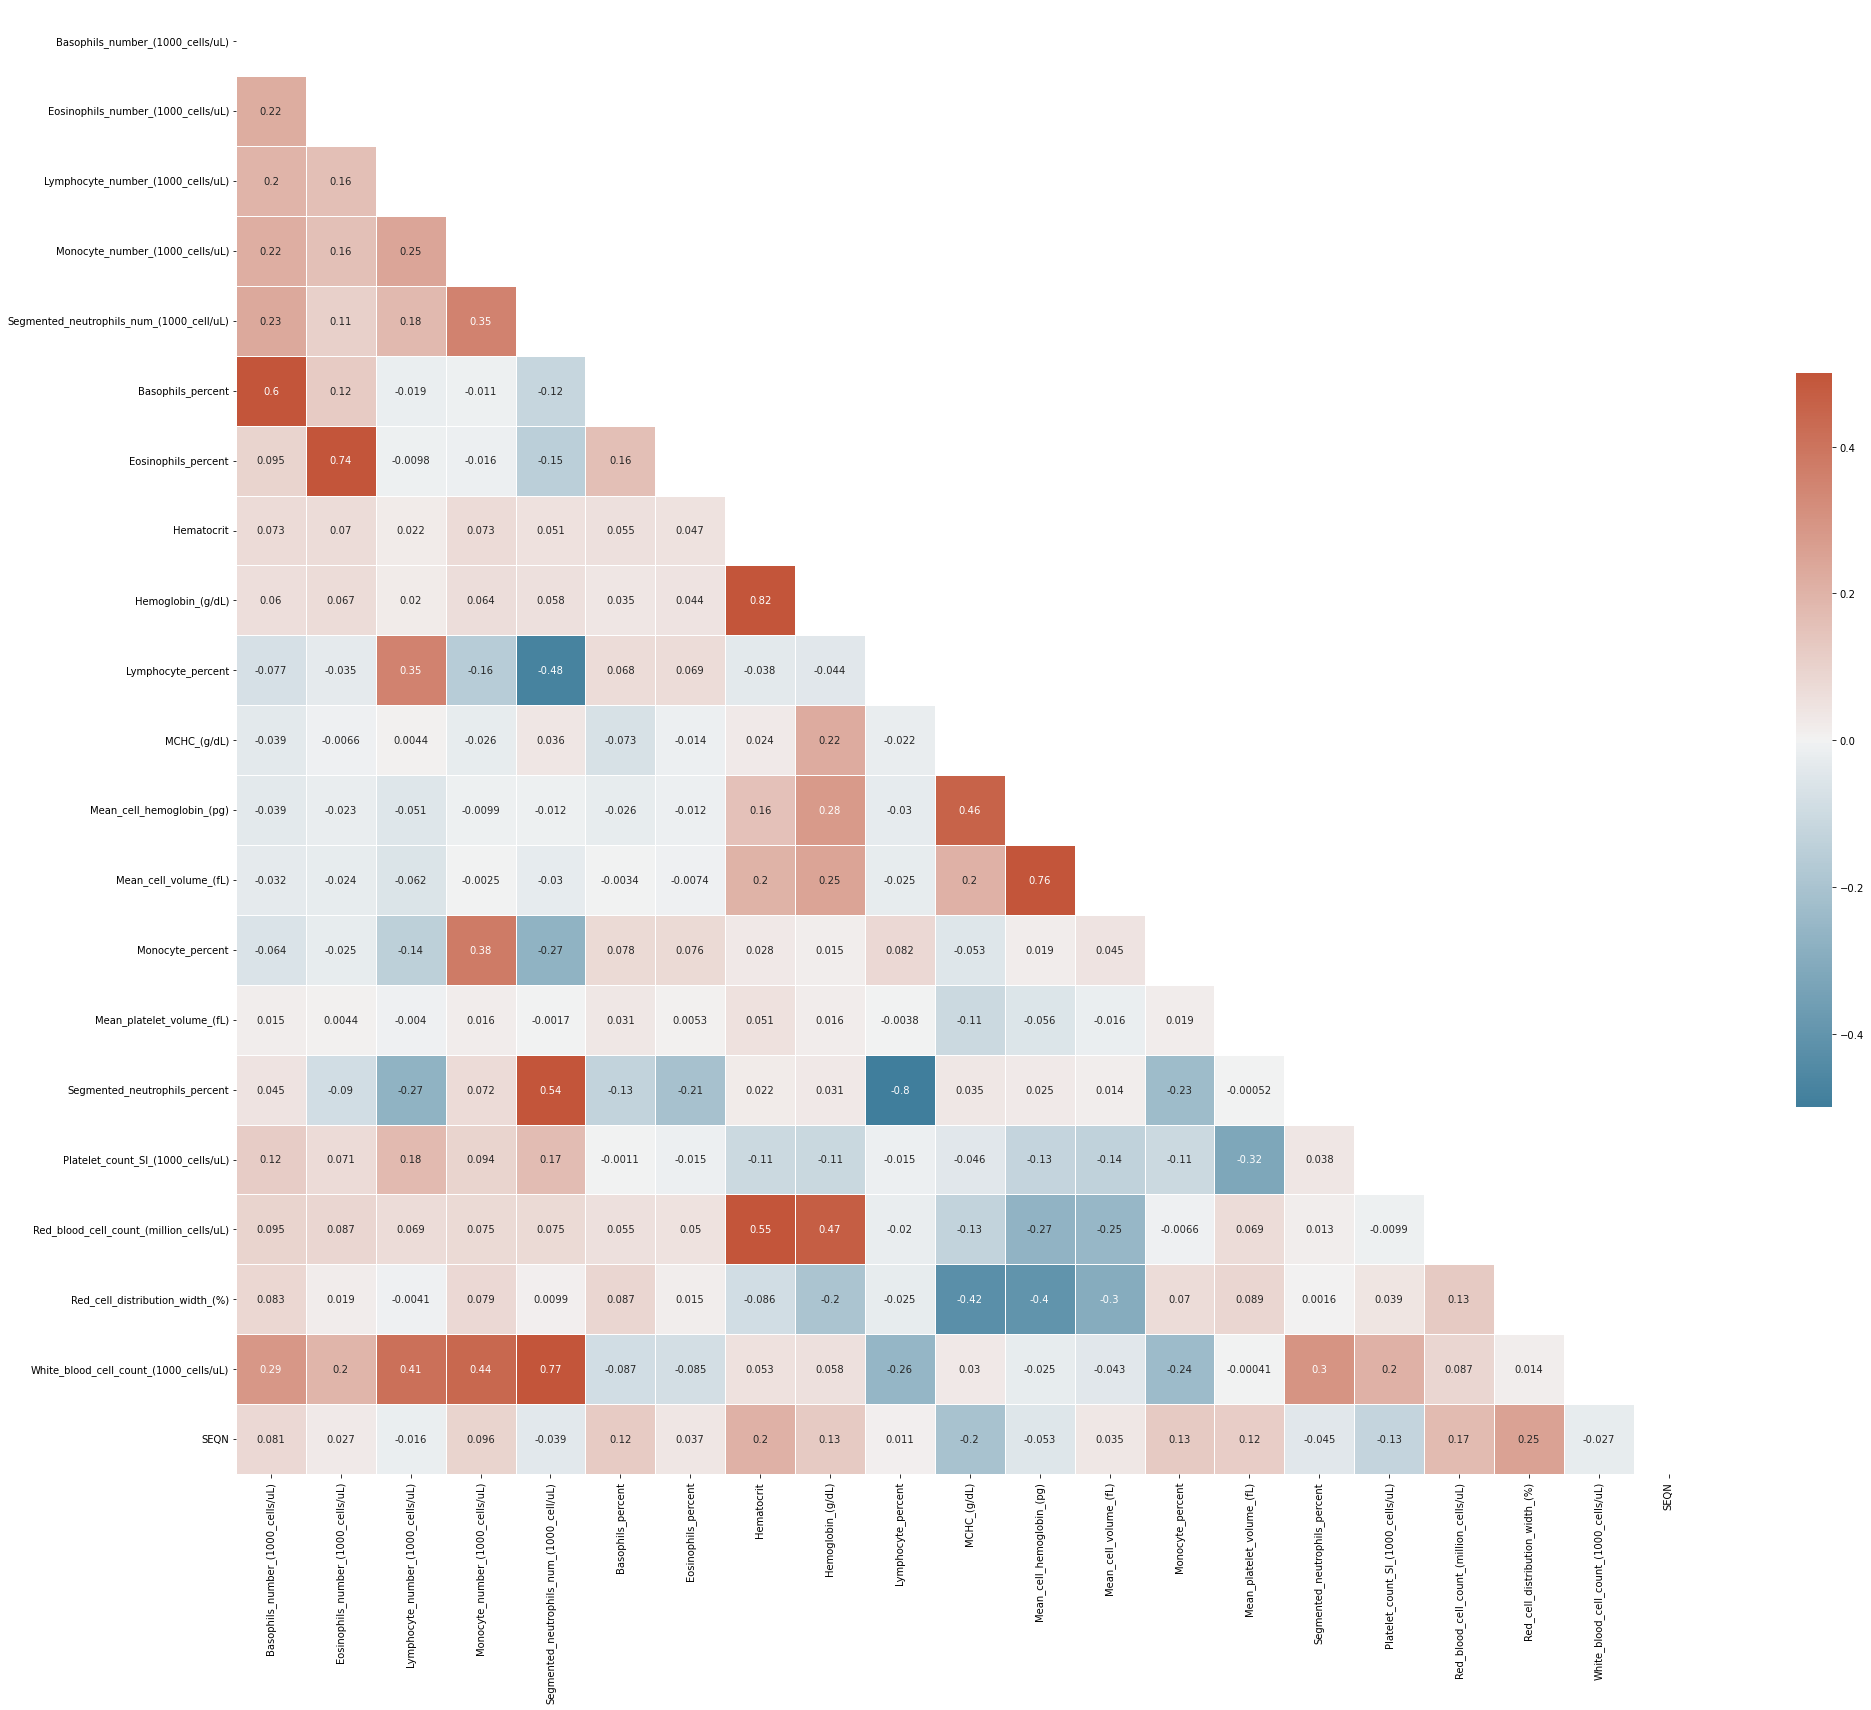

In [461]:
"""Heatmap to visualize correlations between blood markers. To allow for nonlinear relationships between variables, 
we will use the non-parametric Kendall's tau instead of the Pearson correlation coefficient."""

blood_count_corrs = merged_nhanes[blood_count.columns].corr(method = 'kendall')
mask = np.triu(np.ones_like(blood_count_corrs, dtype = bool))

#create a colormap, blue for negative correlations, red for positive
cmap = sns.diverging_palette(230, 20, as_cmap=True)

fig, axes = plt.subplots(figsize = (33,27))
sns.heatmap(blood_count_corrs,
            mask = mask, 
            vmax = 0.5,
            vmin = -0.5,
            center = 0, 
            square = True, 
            linewidths = 0.5, 
            cmap = cmap,
            annot = True,
            cbar_kws = {'shrink':0.5})

Lower levels of cholesterol, bicarbonate, iron, albumin and lactate dehydrogenase in the depressed group. Increased cholesterol, triglycerides, chloride and alkaline phosphatase. 

<AxesSubplot:>

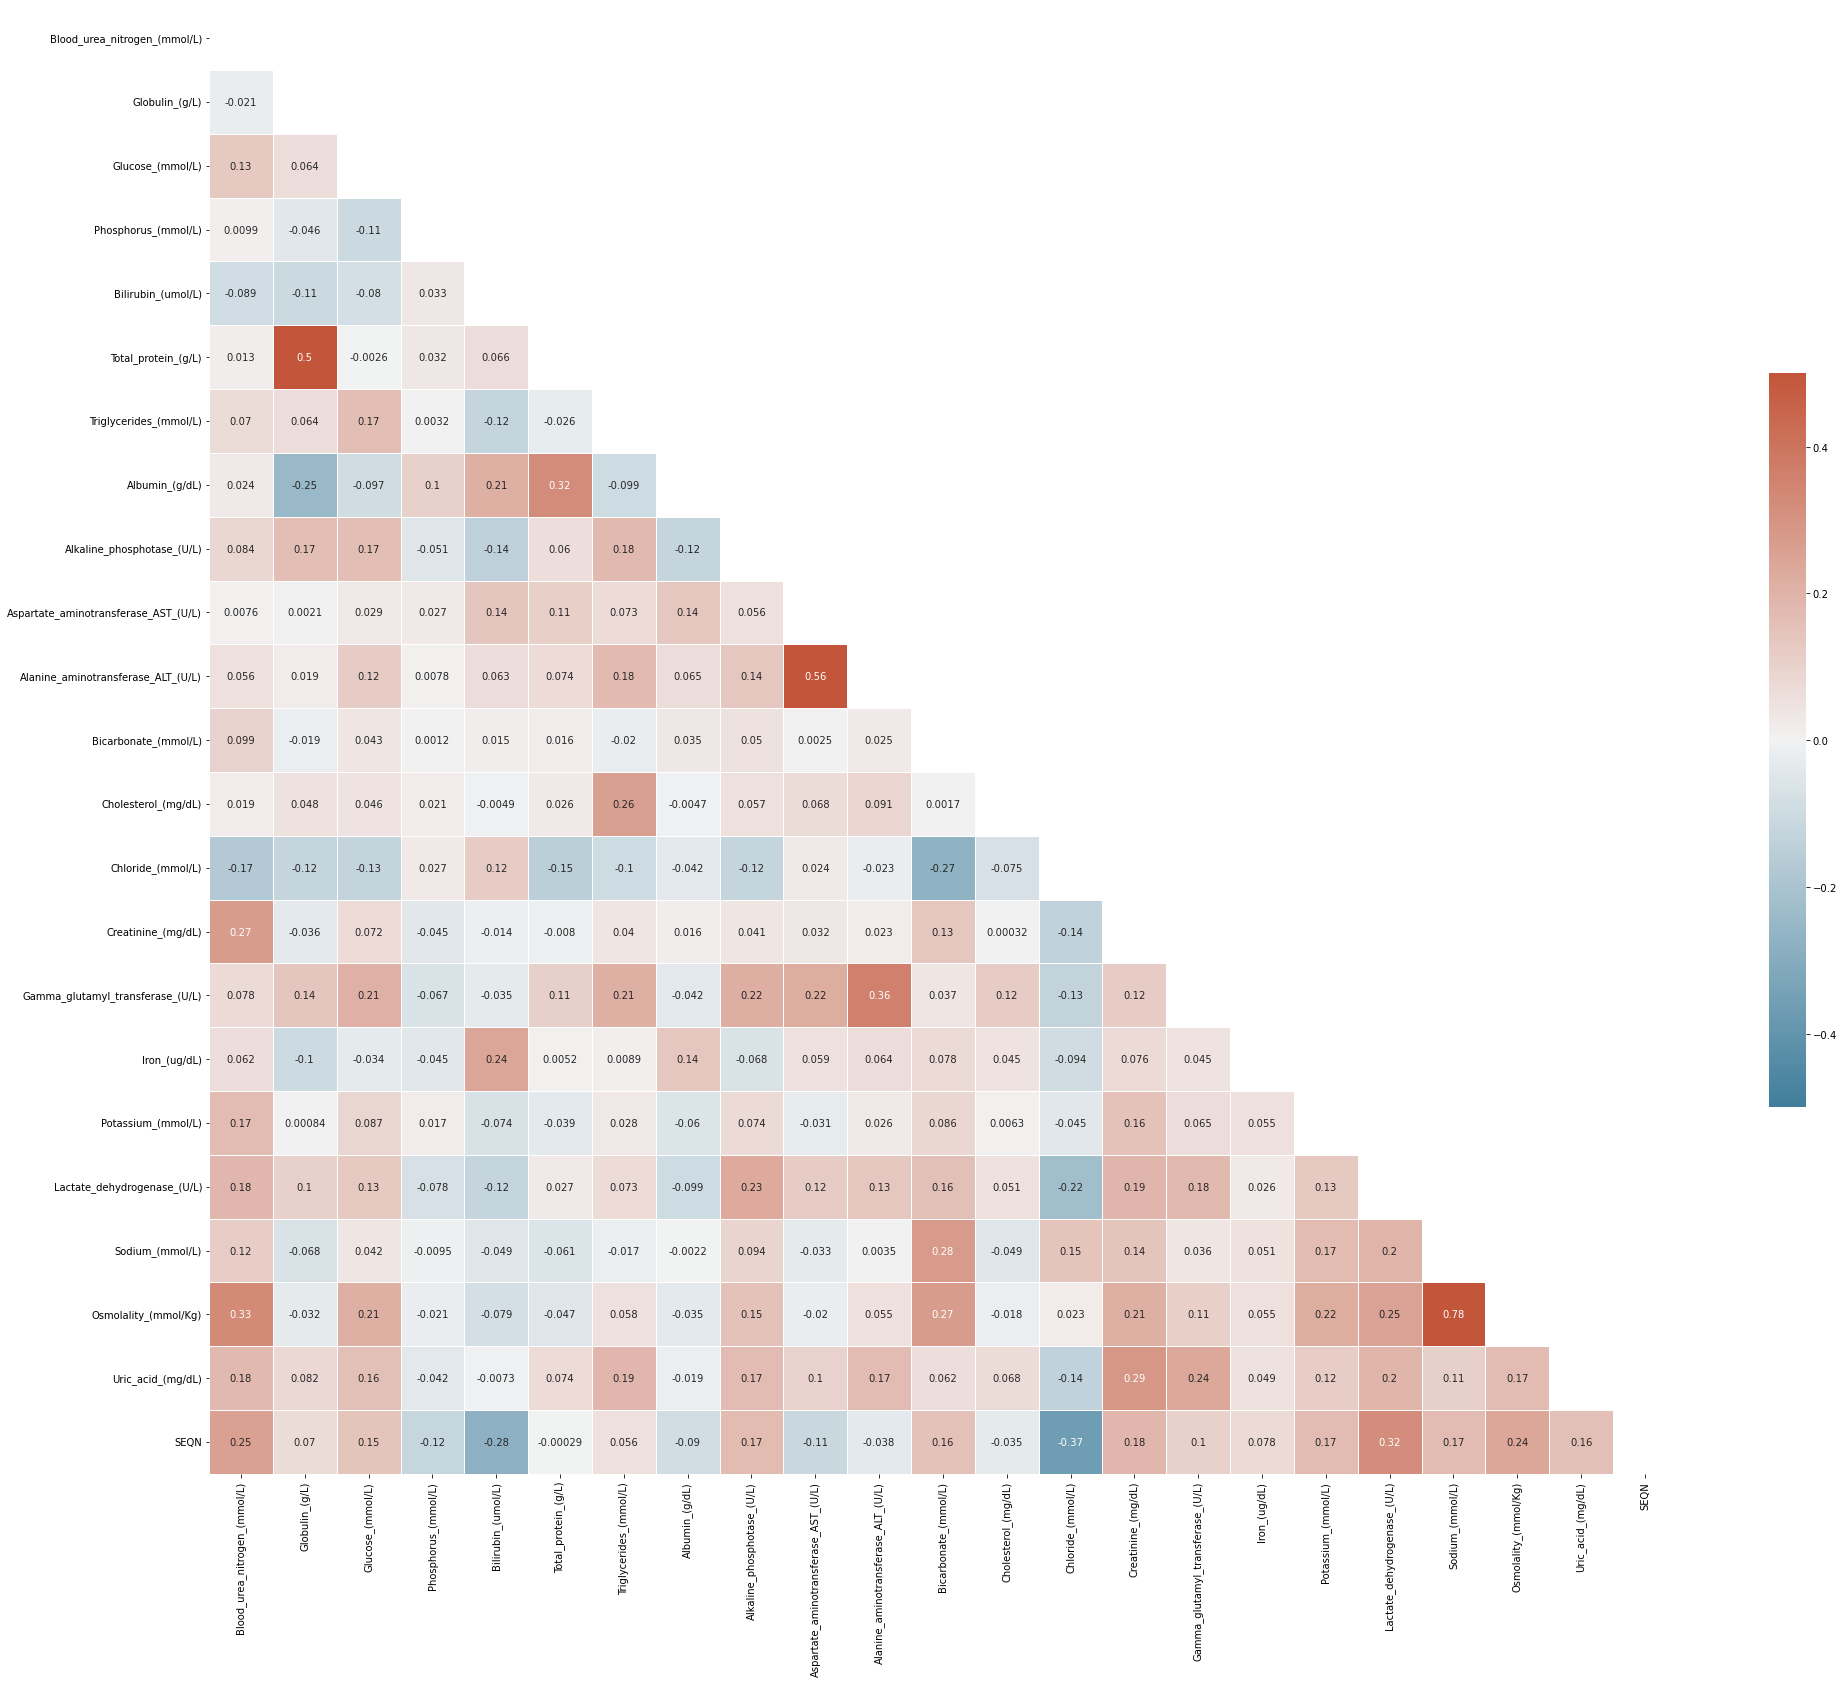

In [460]:
biochem_corrs = merged_nhanes[biochem_profile.columns].corr(method = 'kendall')
mask = np.triu(np.ones_like(biochem_corrs, dtype = bool))

#create a colormap, blue for negative correlations, red for positive
cmap = sns.diverging_palette(230, 20, as_cmap=True)

fig, axes = plt.subplots(figsize = (33,27))
sns.heatmap(biochem_corrs,
            mask = mask, 
            vmax = 0.5,
            vmin = -0.5,
            center = 0, 
            square = True, 
            linewidths = 0.5, 
            cmap = cmap,
            annot = True,
            cbar_kws = {'shrink':0.5})

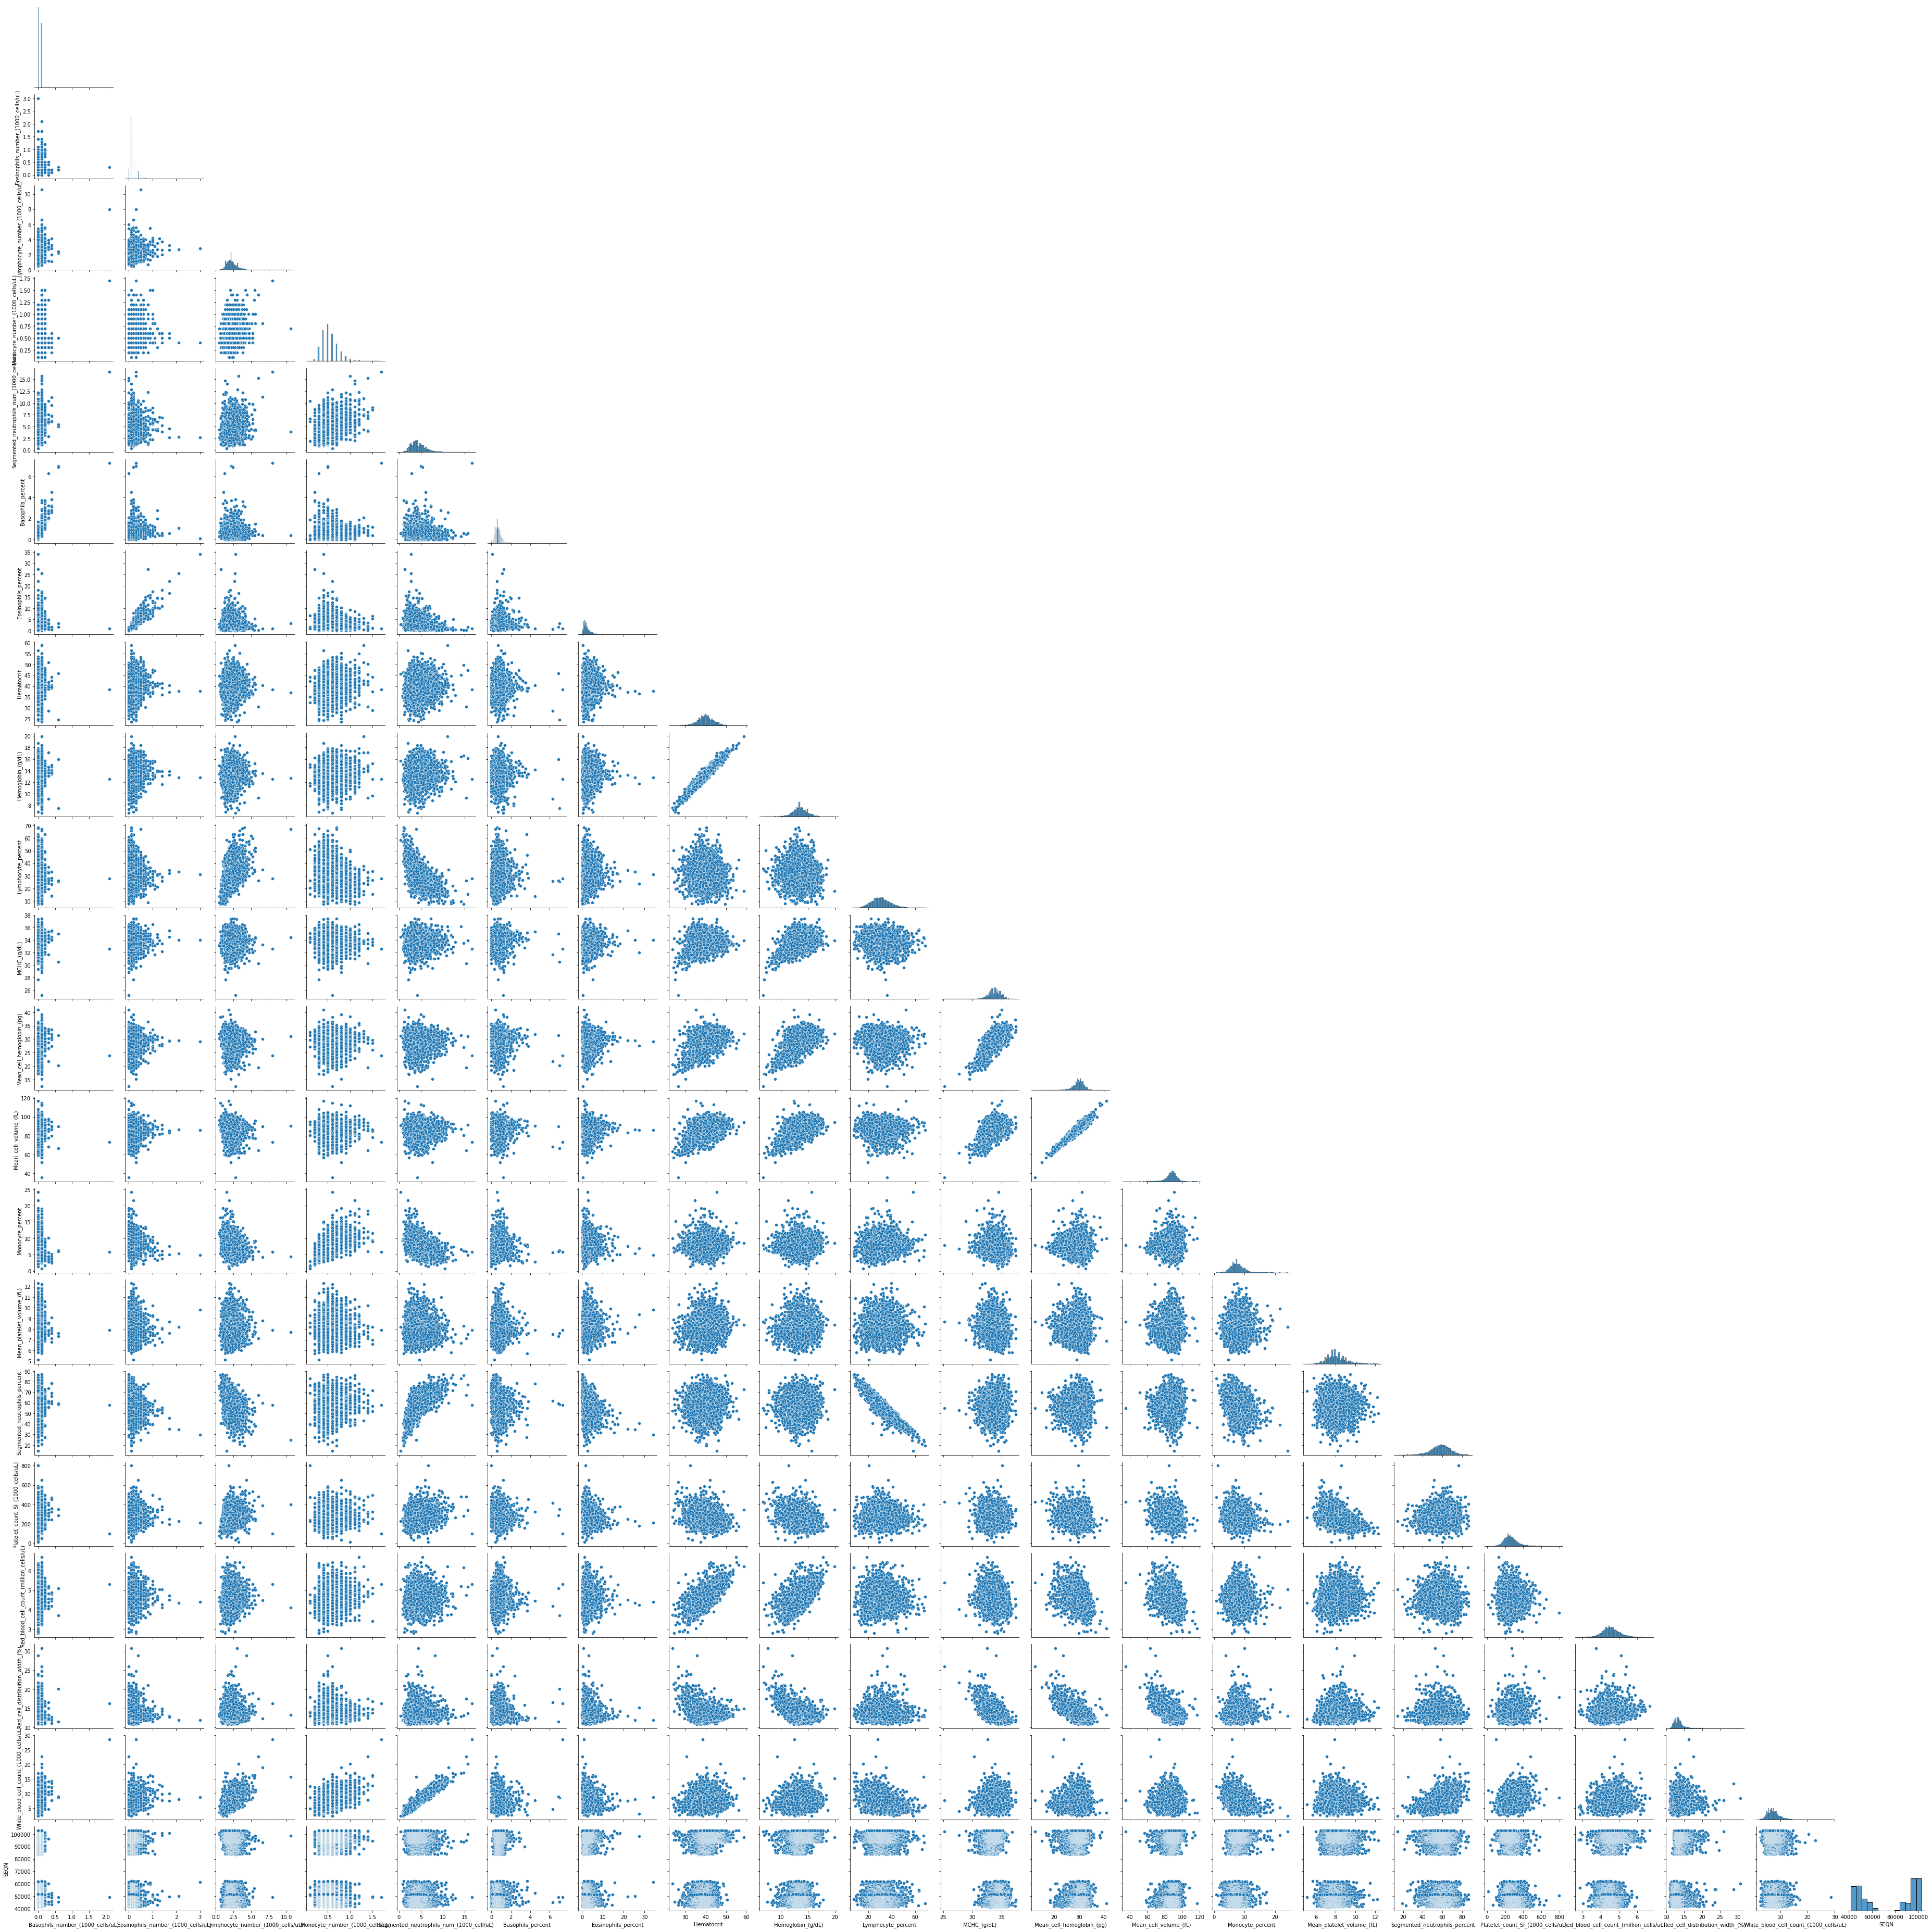

In [95]:
sns.pairplot(data = merged_nhanes[blood_count.columns],corner = True)

<AxesSubplot:>

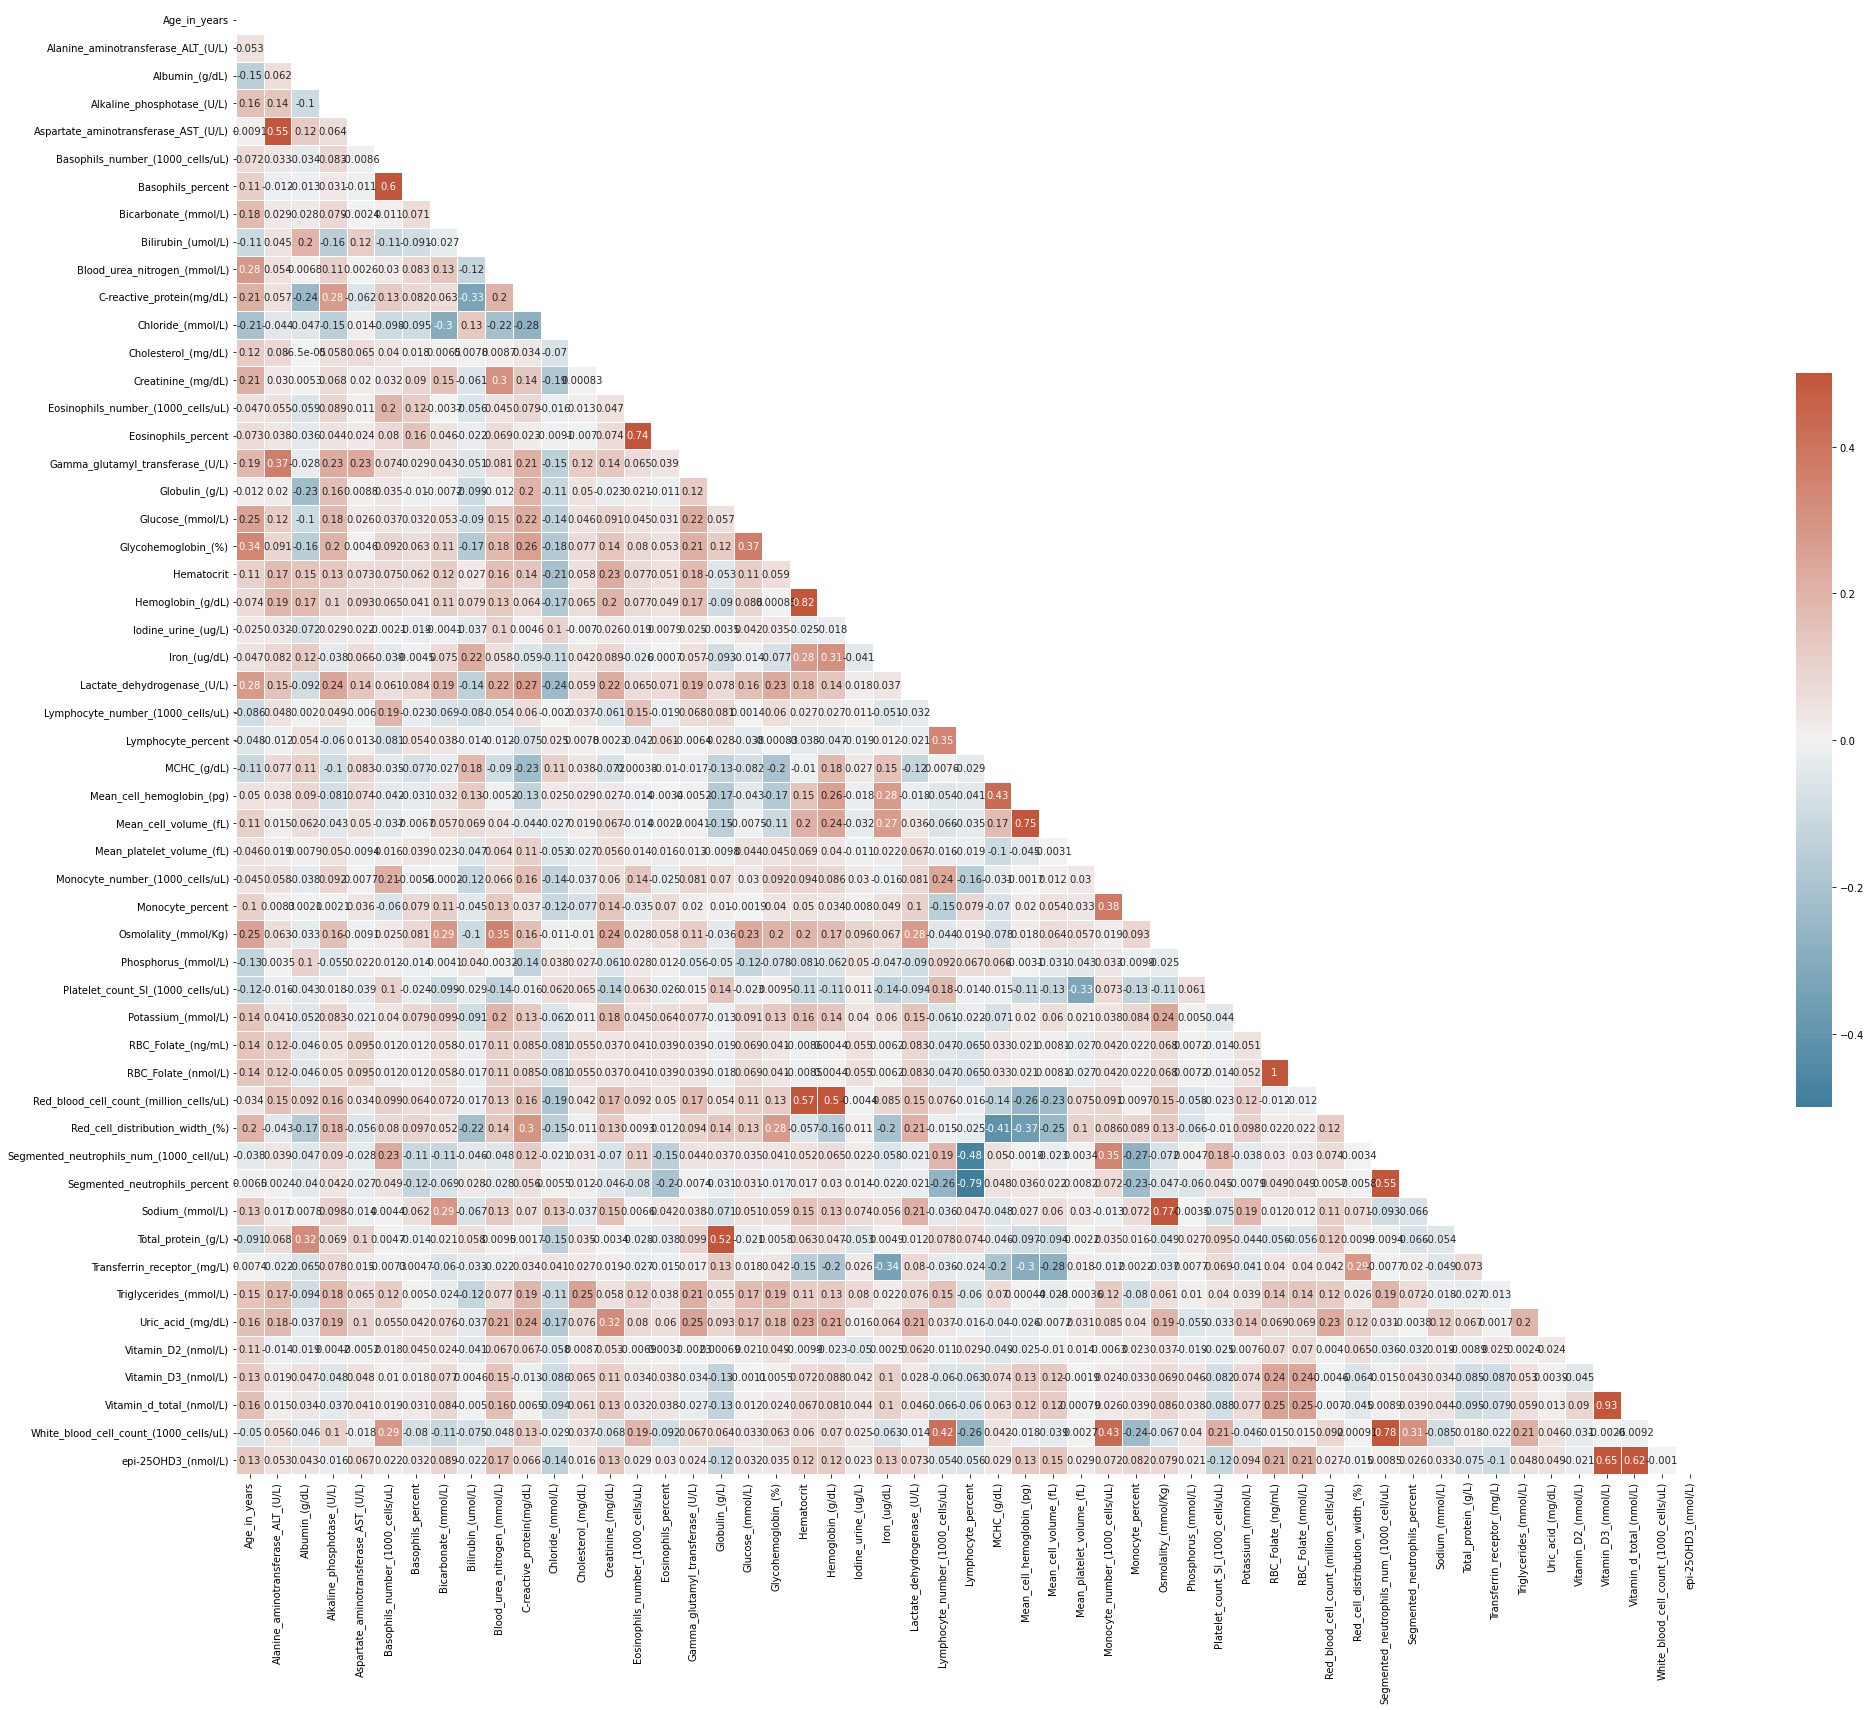

In [100]:
"""Correlation heatmap for all lab values"""

corrs = merged_nhanes[np.setdiff1d(merged_nhanes.columns, depression_screen.columns)].corr( method = 'kendall')

mask = np.triu(np.ones_like(corrs, dtype = bool))

#create a colormap, blue for negative correlations, red for positive
cmap = sns.diverging_palette(230, 20, as_cmap=True)

fig, axes = plt.subplots(figsize = (33,27))
sns.heatmap(corrs,
            mask = mask, 
            vmax = 0.5,
            vmin = -0.5,
            center = 0, 
            square = True, 
            linewidths = 0.5, 
            cmap = cmap,
            annot = True,
            cbar_kws = {'shrink':0.5})

In [ ]:
"""Let's run the model with all missing values imputed. To do so, we will use the MissForest imputation algorithm from
the missingpy package. MissForest uses the random forest algorithm to regress/classify each column with the other
columns in the dataset. """

In [431]:
"""Remove mental health info to prevent data leakage"""
merged_nhanes_for_imputation = merged_nhanes.drop(columns = depression_screen.columns[depression_screen.columns != 'SEQN'],
                                                   axis = 1)


In [432]:
""" Convert race and gender columns to category type"""
merged_nhanes_for_imputation[['Race/ethnicity','Gender']] = merged_nhanes_for_imputation[['Race/ethnicity','Gender']].astype('category')

In [433]:
"""Run MissForest imputer"""

imputer = MissForest()
merged_nhanes_imputed = imputer.fit_transform(merged_nhanes_for_imputation)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, ex

Iteration: 0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, ex

Iteration: 1


/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, ex

Iteration: 2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, ex

Iteration: 3


In [434]:
merged_nhanes_imputed = pd.DataFrame(merged_nhanes_imputed,
                                  columns = merged_nhanes_for_imputation.columns)
merged_nhanes_imputed.isnull().sum()

SEQN                                        0
Age_in_years                                0
Gender                                      0
Race/ethnicity                              0
Blood_urea_nitrogen_(mmol/L)                0
Globulin_(g/L)                              0
Glucose_(mmol/L)                            0
Phosphorus_(mmol/L)                         0
Bilirubin_(umol/L)                          0
Total_protein_(g/L)                         0
Triglycerides_(mmol/L)                      0
Albumin_(g/dL)                              0
Alkaline_phosphotase_(U/L)                  0
Aspartate_aminotransferase_AST_(U/L)        0
Alanine_aminotransferase_ALT_(U/L)          0
Bicarbonate_(mmol/L)                        0
Cholesterol_(mg/dL)                         0
Chloride_(mmol/L)                           0
Creatinine_(mg/dL)                          0
Gamma_glutamyl_transferase_(U/L)            0
Iron_(ug/dL)                                0
Potassium_(mmol/L)                

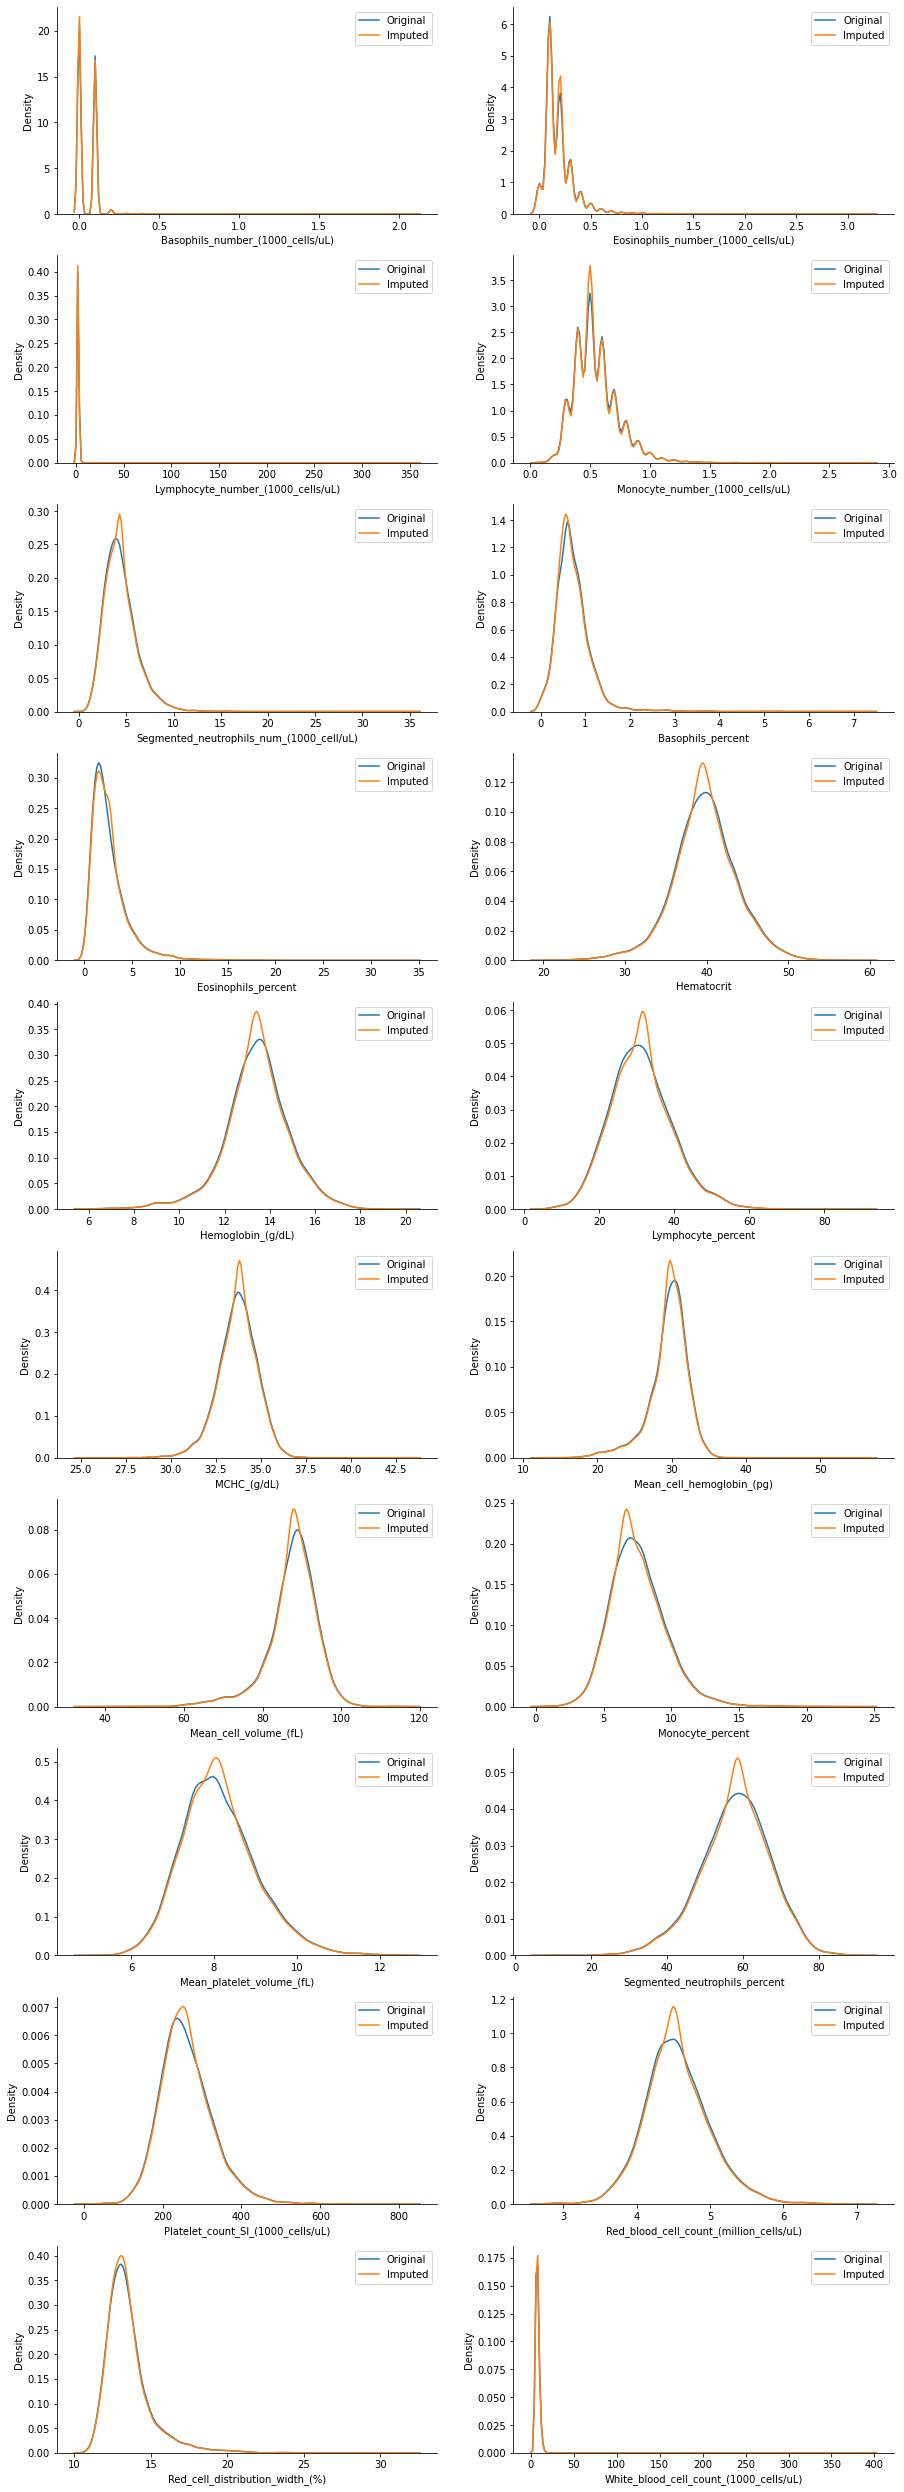

In [435]:
"""Distribution plots to assess imputer performance"""

fig,axs = plt.subplots(nrows = 10, ncols = 2, figsize = (15,45))
for col, ax in zip(blood_count.columns[blood_count.columns != 'SEQN'], axs.ravel()):
    sns.kdeplot(x = col, 
                  data = merged_nhanes,
                  ax = ax,
                label = 'Original')
    sns.kdeplot(x = col, 
                  data = merged_nhanes_imputed,
                  ax = ax,
                label = 'Imputed')
    ax.legend()
    sns.despine()

Overall, the MissForest imputer preserved to general shape of each variable's distrution. It did sharpen the peaks (mode) and narrow the distributions.

In [440]:
merged_nhanes_imputed.columns = merged_nhanes_imputed.columns.str.replace(' ','_')

In [441]:
"""Change 'Depression_rating' variable type to categorical for ordinal regression"""

merged_nhanes['Depression_rating'] = pd.Categorical(merged_nhanes['Depression_rating'],
                                                    categories = ['Not depressed',
                                                                  'Mild',
                                                                  'Moderate',
                                                                  'Moderately severe',
                                                                  'Severe'],
                                                    ordered = True)

In [484]:
"""Run a proportional odds ordinal logistic regression using Statsmodels. This type of regression allows ordinal
variables to modeled with numerical and categorical predictors."""

mod_log = OrderedModel(merged_nhanes['Depression_rating'],
                        merged_nhanes_imputed[['White_blood_cell_count_(1000_cells/uL)',
                                               'Red_cell_distribution_width_(%)',
                                               'Red_blood_cell_count_(million_cells/uL)',
                                               'Lymphocyte_number_(1000_cells/uL)',
                                               'Hematocrit',
                                               'Vitamin_d_total_(nmol/L)',
                                               'Bicarbonate_(mmol/L)',
                                               'Platelet_count_SI_(1000_cells/uL)',
                                               'Chloride_(mmol/L)',
                                               'Blood_urea_nitrogen_(mmol/L)',
                                               'Globulin_(g/L)',
                                               'Cholesterol_(mg/dL)',                                                                    
                                               'Albumin_(g/dL)',                           
                                               'Alkaline_phosphotase_(U/L)',                  
                                               'Aspartate_aminotransferase_AST_(U/L)',        
                                               'Alanine_aminotransferase_ALT_(U/L)',
                                               'Gamma_glutamyl_transferase_(U/L)',
                                               'Triglycerides_(mmol/L)',
                                               'Age_in_years',
                                               'Gender',
                                               'Transferrin_receptor_(mg/L)',
                                               'C-reactive_protein(mg/dL)']],
                        distr='logit')

res_log = mod_log.fit(method='bfgs', disp=False)
res_log.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:      Depression_rating   Log-Likelihood:                -6647.4
Model:                   OrderedModel   AIC:                         1.335e+04
Method:            Maximum Likelihood   BIC:                         1.353e+04
Date:                Thu, 13 Oct 2022                                         
Time:                        17:03:16                                         
No. Observations:                7465                                         
Df Residuals:                    7439                                         
Df Model:                          26                                         
===========================================================================================================
                                              coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
White_blood_cell_count_(1000_cells/uL)      0.0539      0.015      3.601      0.000       0.025       0.083
Red_cell_distribution_width_(%)             0.0784      0.024      3.283      0.001       0.032       0.125
Red_blood_cell_count_(million_cells/uL)    -0.2402      0.102     -2.344      0.019      -0.441      -0.039
Lymphocyte_number_(1000_cells/uL)          -0.0636      0.018     -3.461      0.001      -0.100      -0.028
Hematocrit                                  0.0490      0.014      3.614      0.000       0.022       0.076
Vitamin_d_total_(nmol/L)                   -0.0045      0.001     -4.327      0.000      -0.007      -0.002
Bicarbonate_(mmol/L)                       -0.0197      0.012     -1.620      0.105      -0.044       0.004
Platelet_count_SI_(1000_cells/uL)           0.0008      0.000      1.876      0.061   -3.45e-05       0.002
Chloride_(mmol/L)                           0.0040      0.010      0.403      0.687      -0.015       0.023
Blood_urea_nitrogen_(mmol/L)               -0.0100      0.017     -0.596      0.551      -0.043       0.023
Globulin_(g/L)                             -0.0119      0.007     -1.639      0.101      -0.026       0.002
Cholesterol_(mg/dL)                         0.0008      0.001      1.122      0.262      -0.001       0.002
Albumin_(g/dL)                             -0.1865      0.087     -2.142      0.032      -0.357      -0.016
Alkaline_phosphotase_(U/L)                  0.0018      0.001      1.524      0.128      -0.001       0.004
Aspartate_aminotransferase_AST_(U/L)        0.0021      0.003      0.850      0.395      -0.003       0.007
Alanine_aminotransferase_ALT_(U/L)         -0.0004      0.002     -0.167      0.867      -0.005       0.004
Gamma_glutamyl_transferase_(U/L)            0.0036      0.001      3.957      0.000       0.002       0.005
Triglycerides_(mmol/L)                      0.0517      0.026      2.006      0.045       0.001       0.102
Age_in_years                               -0.0008      0.002     -0.390      0.696      -0.005       0.003
Gender                                      0.6216      0.094      6.604      0.000       0.437       0.806
Transferrin_receptor_(mg/L)                 0.0187      0.016      1.136      0.256      -0.014       0.051
C-reactive_protein(mg/dL)                   0.0035      0.004      0.828      0.408      -0.005       0.012
Not depressed/Mild                          3.4396      1.486      2.314      0.021       0.526       6.353
Mild/Moderate                               0.2124      0.026      8.144      0.000       0.161       0.263
Moderate/Moderately severe                 -0.4341      0.052     -8.300      0.000      -0.537      -0.332
Moderately severe/Severe                   -0.8087      0.080    -10.072      0.000      -0.966      -0.651
==============================

In [479]:
# Define function to output plot of the model coefficients

def coefplot(results, coef_labels = False, vars_to_drop = False):
    '''
    Takes in results of regression model and returns a plot of 
    the coefficients with 95% confidence intervals.
    
    Removes intercept, so if uncentered will return error.
    '''
    # Create dataframe of results summary 
    coef_df = pd.DataFrame(results.summary().tables[1].data)
    
    # Add column names
    coef_df.columns = coef_df.iloc[0]

    # Drop the extra row with column labels
    coef_df = coef_df.drop(0)

    # Set index to variable names 
    coef_df = coef_df.set_index(coef_df.columns[0])
    if coef_labels:
        coef_df = coef_df.rename(index = coef_labels)
    if vars_to_drop:
        coef_df = coef_df.drop(vars_to_drop, axis = 0)
    
    # Change datatype from object to float
    coef_df = coef_df.astype(float)

    # Get errors; (coef - lower bound of conf interval)
    errors = coef_df['coef'] - coef_df['[0.025']
    
    # Append errors column to dataframe
    coef_df['errors'] = errors

    # Drop the constant for plotting
    #coef_df = coef_df.drop(['Intercept'])

    # Sort values by coef ascending
    coef_df = coef_df.sort_values(by=['coef'])

    ### Plot Coefficients ###

    # x-labels
    variables = list(coef_df.index.values)
    
    # Add variables column to dataframe
    coef_df['variables'] = variables
    
    # Set sns plot style back to 'poster'
    # This will make bars wide on plot
    sns.set_context("poster")

    # Define figure, axes, and plot
    fig, ax = plt.subplots(figsize=(9, 6))
    
    # Error bars for 95% confidence interval
    # Can increase capsize to add whiskers
    coef_df.plot(x  ='variables', y = 'coef', kind = 'bar',
                 ax = ax, color='none', fontsize = 20, 
                 ecolor = 'steelblue',capsize = 0,
                 yerr = 'errors', legend = False)
    
    # Set title & labels
    plt.title('Coefficients of Features w/ 95% Confidence Intervals',fontsize=20)
    ax.set_ylabel('Coefficients',fontsize=15)
    ax.set_xlabel('',fontsize = 10)
    
    # Coefficients
    ax.scatter(x=pd.np.arange(coef_df.shape[0]), 
               marker='o', s=80, 
               y=coef_df['coef'], color='black')
    
    # Line to define zero on the y-axis
    ax.axhline(y = 0, linestyle = '--', color = 'red', linewidth = 1)
    
    return plt.show()

In [480]:
"""Strip parenthetic strings, underscores, and extraneous whitespace from column names"""
cols_for_plotting = []
for col in merged_nhanes_imputed.columns:
    col = re.sub("[\(\[].*?[\)\]]", "", col).replace('_',' ').strip()
    cols_for_plotting.append(col)

cols_for_plotting = {merged_nhanes_imputed.columns[i]:cols_for_plotting[i] for i in range(len(cols_for_plotting))}

/var/folders/v9/483tmlvj28ldt2s2wvphywvxd4j0g_/T/ipykernel_13572/3576073134.py:69: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  ax.scatter(x=pd.np.arange(coef_df.shape[0]),


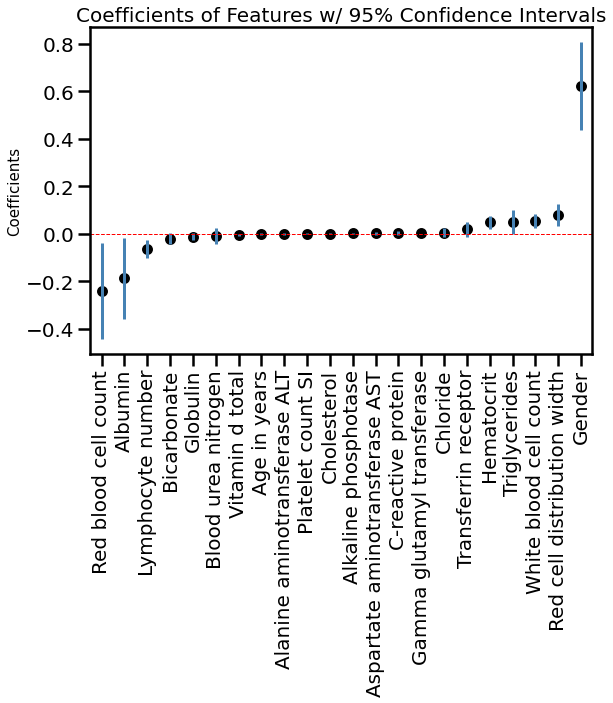

In [481]:
coefplot(res_log, 
         coef_labels = cols_for_plotting,
         vars_to_drop = ['Not depressed/Mild',
                          'Mild/Moderate',
                          'Moderate/Moderately severe',
                          'Moderately severe/Severe'])